In [397]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns
from scipy.stats import pearsonr
import pingouin as pg
import ast
from sklearn.linear_model import LinearRegression, Lasso, LassoCV
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from collections import Counter
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
import pickle as pk

In [398]:
data = pd.read_csv('./housing.csv') 

print(data.columns)

Index(['Title', 'Address', 'City', 'Price', 'Bedroom', 'Bathroom', 'Floors',
       'Parking', 'Face', 'Year', 'Views', 'Area', 'Road', 'Road Width',
       'Road Type', 'Build Area', 'Posted', 'Amenities'],
      dtype='object')


In [399]:
print(data.isna().sum())


Title            0
Address          0
City             0
Price            0
Bedroom          0
Bathroom         0
Floors        1172
Parking          0
Face             0
Year          1629
Views            0
Area             0
Road             0
Road Width       0
Road Type      785
Build Area       0
Posted           0
Amenities        0
dtype: int64


In [400]:
print(data['Road Width'].head(60))

0     20 Feet 
1     20 Feet 
2     20 Feet 
3     20 Feet 
4     20 Feet 
5     13 Feet 
6     11 Feet 
7     20 Feet 
8     20 Feet 
9     12 Feet 
10    15 Feet 
11    14 Feet 
12    12 Feet 
13    20 Feet 
14    13 Feet 
15    13 Feet 
16    20 Feet 
17     13 Feet
18      0 Feet
19     10 Feet
20    10 Feet 
21    20 Feet 
22    20 Feet 
23    20 Feet 
24    13 Feet 
25     32 Feet
26    13 Feet 
27    13 Feet 
28    16 Feet 
29    13 Feet 
30    13 Feet 
31     13 Feet
32    15 Feet 
33    15 Feet 
34    15 Feet 
35    16 Feet 
36    15 Feet 
37    14 Feet 
38    20 Feet 
39    18 Feet 
40    15 Feet 
41     15 Feet
42    13 Feet 
43    15 Feet 
44    14 Feet 
45    13 Feet 
46    13 Feet 
47    13 Feet 
48    13 Feet 
49    26 Feet 
50    14 Feet 
51    13 Feet 
52    15 Feet 
53    13 Feet 
54     13 Feet
55    20 Feet 
56    6 Meter 
57     29 Feet
58      0 Feet
59      0 Feet
Name: Road Width, dtype: object


In [401]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2211 entries, 0 to 2210
Data columns (total 18 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Title       2211 non-null   object 
 1   Address     2211 non-null   object 
 2   City        2211 non-null   object 
 3   Price       2211 non-null   int64  
 4   Bedroom     2211 non-null   int64  
 5   Bathroom    2211 non-null   int64  
 6   Floors      1039 non-null   float64
 7   Parking     2211 non-null   int64  
 8   Face        2211 non-null   object 
 9   Year        582 non-null    float64
 10  Views       2211 non-null   object 
 11  Area        2211 non-null   object 
 12  Road        2211 non-null   object 
 13  Road Width  2211 non-null   object 
 14  Road Type   1426 non-null   object 
 15  Build Area  2211 non-null   object 
 16  Posted      2211 non-null   object 
 17  Amenities   2211 non-null   object 
dtypes: float64(2), int64(4), object(12)
memory usage: 311.1+ KB
None


In [402]:
data['New Year'] = data['Year'].fillna(0).astype('int')

assert data['New Year'].dtype == 'int'


<Axes: >

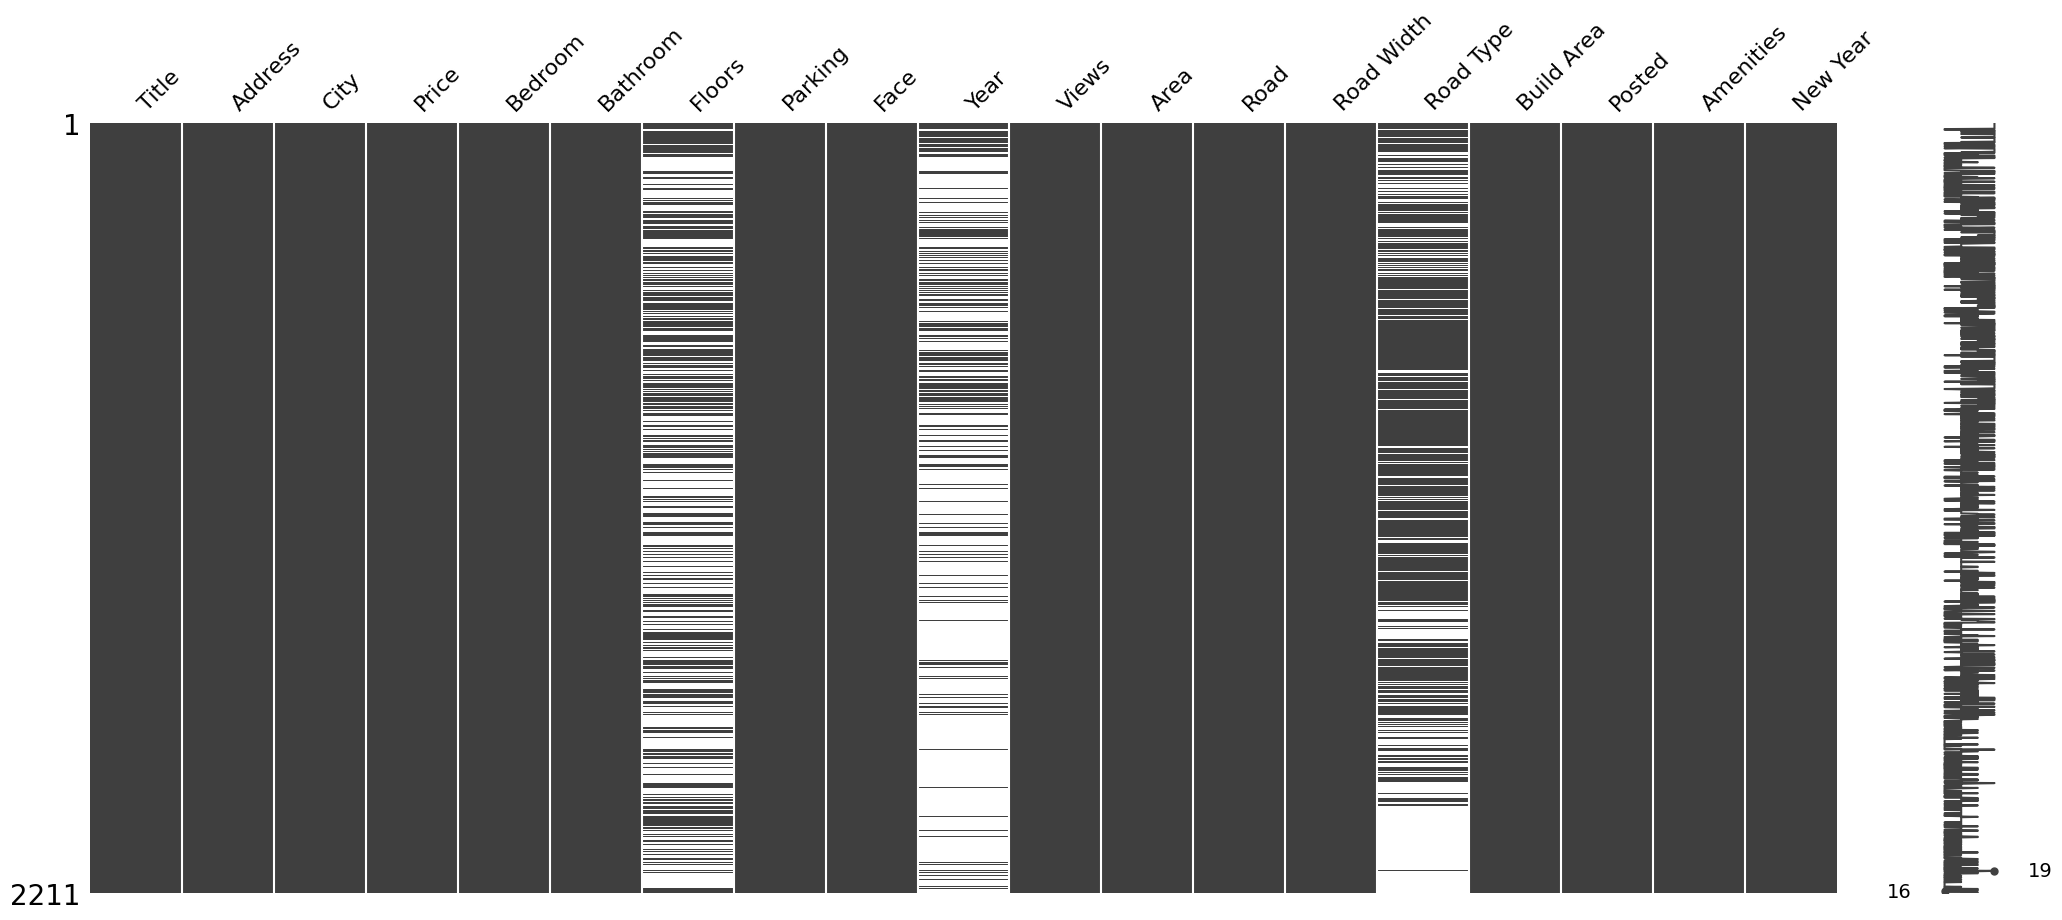

In [403]:
msno.matrix(data)

In [404]:
print(data['Views'])

0          17
1          26
2         154
3          17
4          59
        ...  
2206     3.1K
2207     1.4K
2208     1.5K
2209     2.5K
2210    19.6K
Name: Views, Length: 2211, dtype: object


In [405]:
def sen_changer(value):
    if 'K' in value:
        return int(float(value.replace('K', '')) * 1000)
    return value

data['New Views'] = data['Views'].apply(sen_changer)

In [406]:

data['New Views'] = data['New Views'].astype('int')


In [407]:
def feet_converter(value):
    if 'Feet' in value:
        return float(value.replace(' Feet', '').strip())
    elif 'Meter' in value:
        return float(value.replace(' Meter', '').strip())
    else:
        return float(value.strip())

data['New Width'] = data['Road Width'].apply(feet_converter)

assert data['New Width'].dtype == 'float'


In [408]:
print(data['New Width'])
print(data['New Year'])
print(data['New Views'])

0       20.0
1       20.0
2       20.0
3       20.0
4       20.0
        ... 
2206    16.0
2207    13.0
2208    12.0
2209    13.0
2210    12.0
Name: New Width, Length: 2211, dtype: float64
0       2073
1       2073
2       2071
3       2017
4       2070
        ... 
2206       0
2207       0
2208    2071
2209       0
2210       0
Name: New Year, Length: 2211, dtype: int64
0          17
1          26
2         154
3          17
4          59
        ...  
2206     3100
2207     1400
2208     1500
2209     2500
2210    19600
Name: New Views, Length: 2211, dtype: int64


In [409]:
price_q1 = np.quantile(data['Price'], 0.25)
price_q3 = np.quantile(data['Price'], 0.75)
iqr = price_q3 - price_q1
price_lowerer = np.quantile(data['Price'], 0.30)
price_lower = np.quantile(data['Price'], 0.35)


In [410]:
price_upper_bound = price_q3 + 1.5 * iqr

data.loc[data['Price'] > price_upper_bound, 'Price'] = price_upper_bound

print(data['Price'])

0       64300000
1       64300000
2       64300000
3       64300000
4       64300000
          ...   
2206      500000
2207    12000000
2208    27000000
2209      300000
2210    64300000
Name: Price, Length: 2211, dtype: int64


In [411]:
data.loc[data['Price'] < price_q1, 'Price'] = price_q1
print(data['Price'])

0       64300000
1       64300000
2       64300000
3       64300000
4       64300000
          ...   
2206     1300000
2207    12000000
2208    27000000
2209     1300000
2210    64300000
Name: Price, Length: 2211, dtype: int64


In [412]:
bedroom_q1 = np.quantile(data['Bedroom'], 0.25)
bedroom_q3 = np.quantile(data['Bedroom'], 0.75)
bedroom_iqr = bedroom_q3 - bedroom_q1

print(bedroom_q1)
print(bedroom_q3)

0.0
5.0


In [413]:
bedroom_upper_bound = int(bedroom_q3 + 1.5 * bedroom_iqr)
print(bedroom_upper_bound)

12


In [414]:
data.loc[data['Bedroom'] > bedroom_upper_bound, 'Bedroom'] = bedroom_upper_bound

data.loc[data['Bedroom'] == 0, 'Bedroom'] = 1

print(data['Bedroom'].value_counts())

Bedroom
1     1132
5      246
4      224
6      161
3      118
2      110
7       68
12      48
8       35
10      29
9       20
11      20
Name: count, dtype: int64


In [415]:
bathroom_q1 = np.quantile(data['Bathroom'], 0.25)
bathroom_q3 = np.quantile(data['Bathroom'], 0.75)

bathroom_iqr = bathroom_q3 - bathroom_q1

print(bathroom_iqr)

4.0


In [416]:
upper_bathroom = bathroom_q3 + 1.5 * bathroom_iqr

data.loc[data['Bathroom'] > upper_bathroom, 'Bathroom'] = upper_bathroom

data.loc[(data['Bathroom'] == 0) & (data['New Year'] <= 2055), 'Bathroom'] = bathroom_q3

data.loc[(data['Bathroom'] == 0) & (data['New Year'] <= 2055) & (data['New Year'] >= 2065), 'Bathroom'] = 2

data.loc[(data['Bathroom'] == 0), 'Bathroom'] = 1

In [417]:
parking_q1 = np.quantile(data['Parking'], 0.25)
parking_q3 = np.quantile(data['Parking'], 0.75)

parking_iqr = parking_q3 - parking_q1


In [418]:
upper_parking = int(parking_q3 + 1.5 * parking_iqr)

data.loc[data['Parking'] > upper_parking, 'Parking'] = upper_parking

print(data['Parking'].value_counts())

Parking
0    1322
2     489
1     400
Name: count, dtype: int64


In [419]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2211 entries, 0 to 2210
Data columns (total 21 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Title       2211 non-null   object 
 1   Address     2211 non-null   object 
 2   City        2211 non-null   object 
 3   Price       2211 non-null   int64  
 4   Bedroom     2211 non-null   int64  
 5   Bathroom    2211 non-null   int64  
 6   Floors      1039 non-null   float64
 7   Parking     2211 non-null   int64  
 8   Face        2211 non-null   object 
 9   Year        582 non-null    float64
 10  Views       2211 non-null   object 
 11  Area        2211 non-null   object 
 12  Road        2211 non-null   object 
 13  Road Width  2211 non-null   object 
 14  Road Type   1426 non-null   object 
 15  Build Area  2211 non-null   object 
 16  Posted      2211 non-null   object 
 17  Amenities   2211 non-null   object 
 18  New Year    2211 non-null   int64  
 19  New Views   2211 non-null  

In [420]:
print(data['City'].value_counts())

City
Kathmandu      1483
Lalitpur        432
Bhaktapur        85
Pokhara          64
Chitwan          33
Makwanpur        12
Nawalparasi      12
Dharan           11
Jhapa            10
Kavre             7
Kirtipur          7
Sunsari           7
Butwal            6
Biratnagar        6
Parsa             4
Bara              4
Dhading           4
Morang            4
Itahari           3
Kaski             3
Rupandehi         3
Birtamod          1
Nawalpur          1
Mahottari         1
Dang              1
Bardiya           1
Bhairahawa        1
Surkhet           1
Kapilvastu        1
Tanahu            1
Illam             1
Kailali           1
Name: count, dtype: int64


In [421]:
conditions = [(data['New Year'] >= 2065) & (data['Price'] < 10000000), (data['New Year'] >= 2065) & (data['Price'] >= 10000000) & (data['Price'] <= 30000000), (data['New Year'] >= 2065) & (data['Price'] > 30000000), (data['New Year'] < 2065) & (data['Price'] < 1500000), (data['New Year'] < 2065) & (data['Price'] >= 1500000)]
choices = ['Low', 'Medium', 'High', 'Medium', 'High']

data['Price Category'] = np.select(conditions, choices, default = 'Unkown')

print(data.loc[:, ['Price', 'Year', 'Price Category']].head(50))

       Price    Year Price Category
0   64300000  2073.0           High
1   64300000  2073.0           High
2   64300000  2071.0           High
3   64300000  2017.0           High
4   64300000  2070.0           High
5   64300000  2074.0           High
6   11000000  2019.0           High
7   50000000  2073.0           High
8   64300000  2017.0           High
9   32500000  2065.0           High
10  32000000  2075.0           High
11  39900000  2075.0           High
12  15000000  2074.0         Medium
13  52500000  2075.0           High
14  26500000  2076.0         Medium
15  25500000  2076.0         Medium
16  33000000  2056.0           High
17  18500000     NaN           High
18  62000000     NaN           High
19  10500000     NaN           High
20  20500000  2076.0         Medium
21  22000000     NaN           High
22  64300000  2073.0           High
23  55000000  2071.0           High
24  24000000  2075.0         Medium
25  37000000     NaN           High
26  64300000  2070.0        

In [422]:
print(data['Floors'].isna().sum())
print(data['Floors'].value_counts(dropna=False))

1172
Floors
NaN      1172
3.00      562
2.00      166
4.00       84
1.00       58
2.50       54
0.00       38
5.00       25
1.50       14
3.50       10
6.00        8
7.00        5
10.00       4
4.50        3
12.00       2
9.00        2
13.00       1
1.35        1
5.50        1
8.00        1
Name: count, dtype: int64


In [423]:
missing_floor = data[data['Floors'].isna()]
complete_floor = data[~data['Floors'].isna()]

In [424]:
missing_floor.describe()

,Price,Bedroom,Bathroom,Floors,Parking,Year,New Year,New Views,New Width
count,1.172000e+03,1172.000000,1172.000000,0.0,1172.000000,49.000000,1172.000000,1172.000000,1172.000000
mean,9.551681e+06,1.818259,3.858362,NaN,0.220990,2045.408163,85.516212,629.557167,16.518345
std,1.521631e+07,2.048575,0.889491,NaN,0.572471,29.075991,409.609957,1299.586890,31.033237
min,1.300000e+06,1.000000,1.000000,NaN,0.000000,2002.000000,0.000000,23.000000,0.000000
25%,1.300000e+06,1.000000,4.000000,NaN,0.000000,2018.000000,0.000000,259.000000,12.000000
50%,2.600000e+06,1.000000,4.000000,NaN,0.000000,2065.000000,0.000000,371.000000,14.000000
75%,8.500000e+06,1.000000,4.000000,NaN,0.000000,2074.000000,0.000000,556.500000,20.000000
max,6.430000e+07,12.000000,10.000000,NaN,2.000000,2076.000000,2076.000000,24700.000000,500.000000


In [425]:
complete_floor.describe()

,Price,Bedroom,Bathroom,Floors,Parking,Year,New Year,New Views,New Width
count,1.039000e+03,1039.000000,1039.000000,1039.000000,1039.000000,533.000000,1039.000000,1039.000000,1039.000000
mean,2.569738e+07,4.512993,3.840231,2.824206,1.076997,2058.917448,1056.210780,1220.851781,15.242541
std,1.963685e+07,2.712558,1.646939,1.265411,0.826955,25.538205,1029.768983,2794.173546,7.772220
min,1.300000e+06,1.000000,1.000000,0.000000,0.000000,1994.000000,0.000000,17.000000,0.000000
25%,1.145000e+07,2.000000,3.000000,2.000000,0.000000,2045.000000,0.000000,300.000000,13.000000
50%,2.250000e+07,5.000000,4.000000,3.000000,1.000000,2074.000000,2007.000000,466.000000,14.000000
75%,3.700000e+07,6.000000,5.000000,3.000000,2.000000,2076.000000,2074.000000,835.000000,20.000000
max,6.430000e+07,12.000000,10.000000,13.000000,2.000000,2077.000000,2077.000000,44200.000000,150.000000


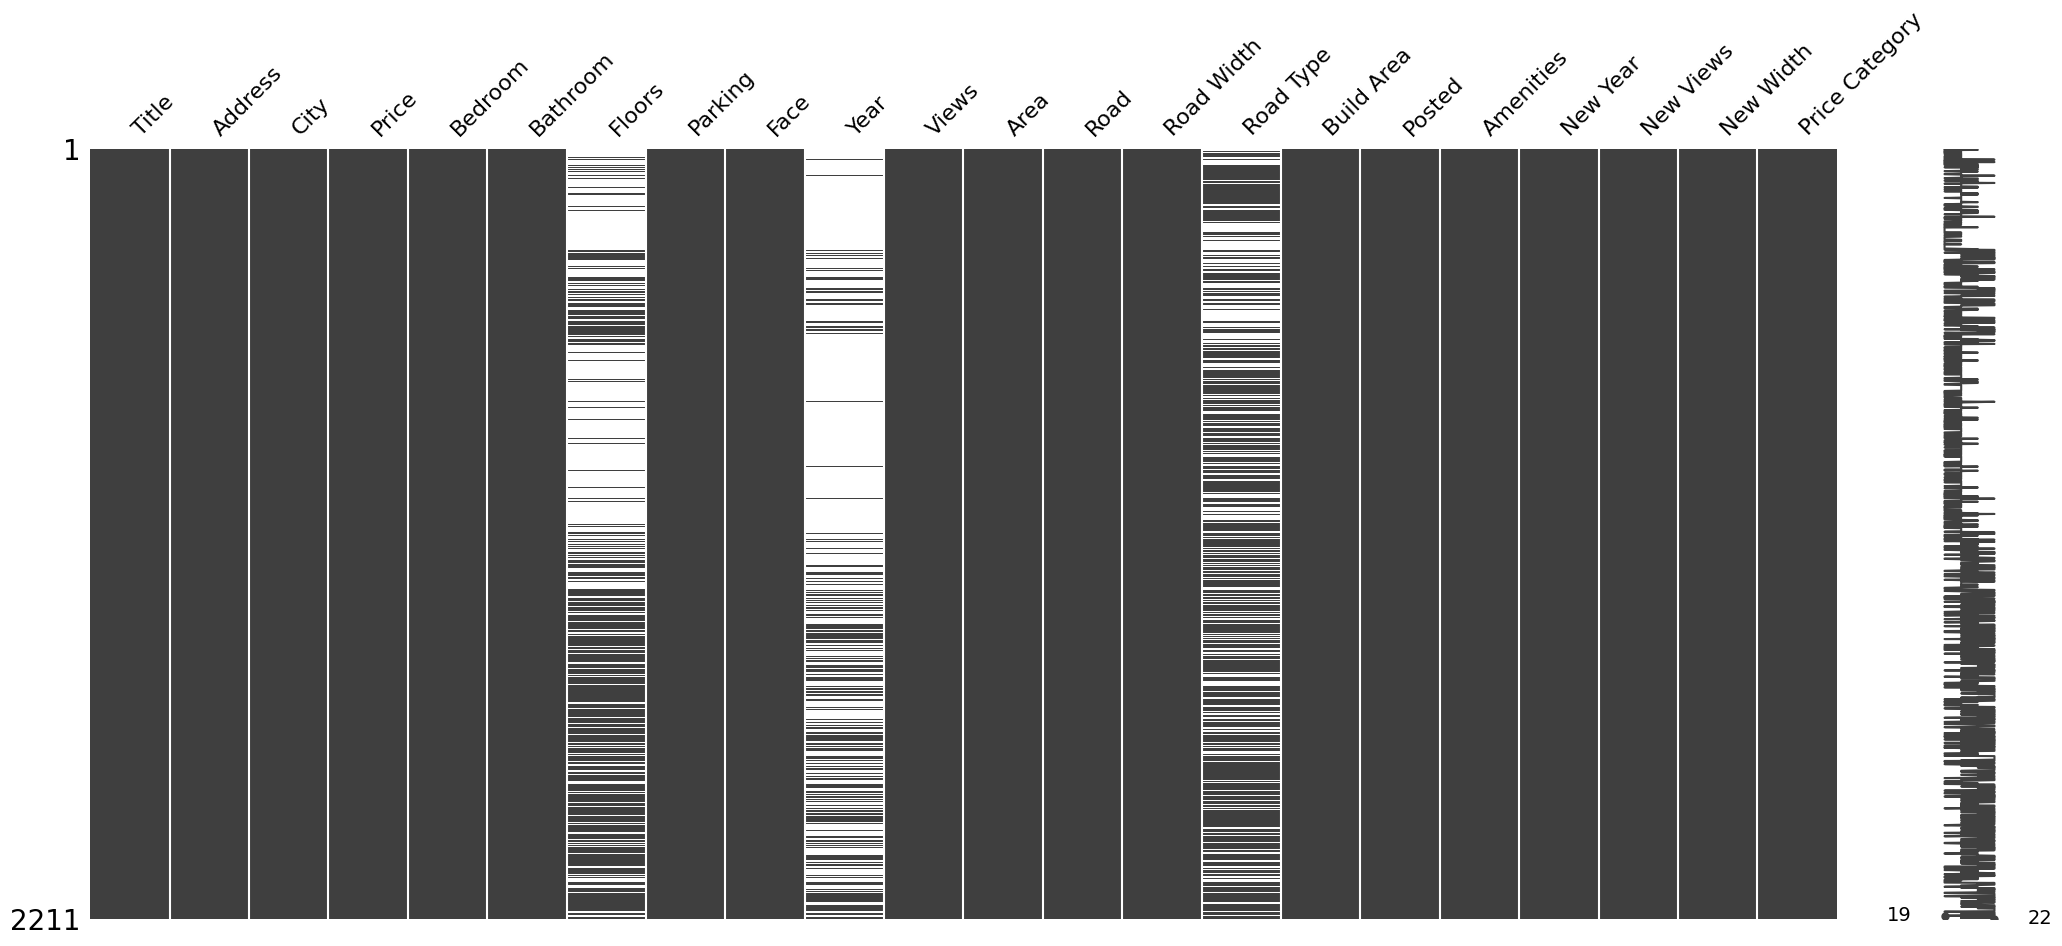

In [426]:
sorted_floor = data.sort_values(by = ['Price', 'Bedroom', 'Parking'])
msno.matrix(sorted_floor)
plt.show()

<Axes: >

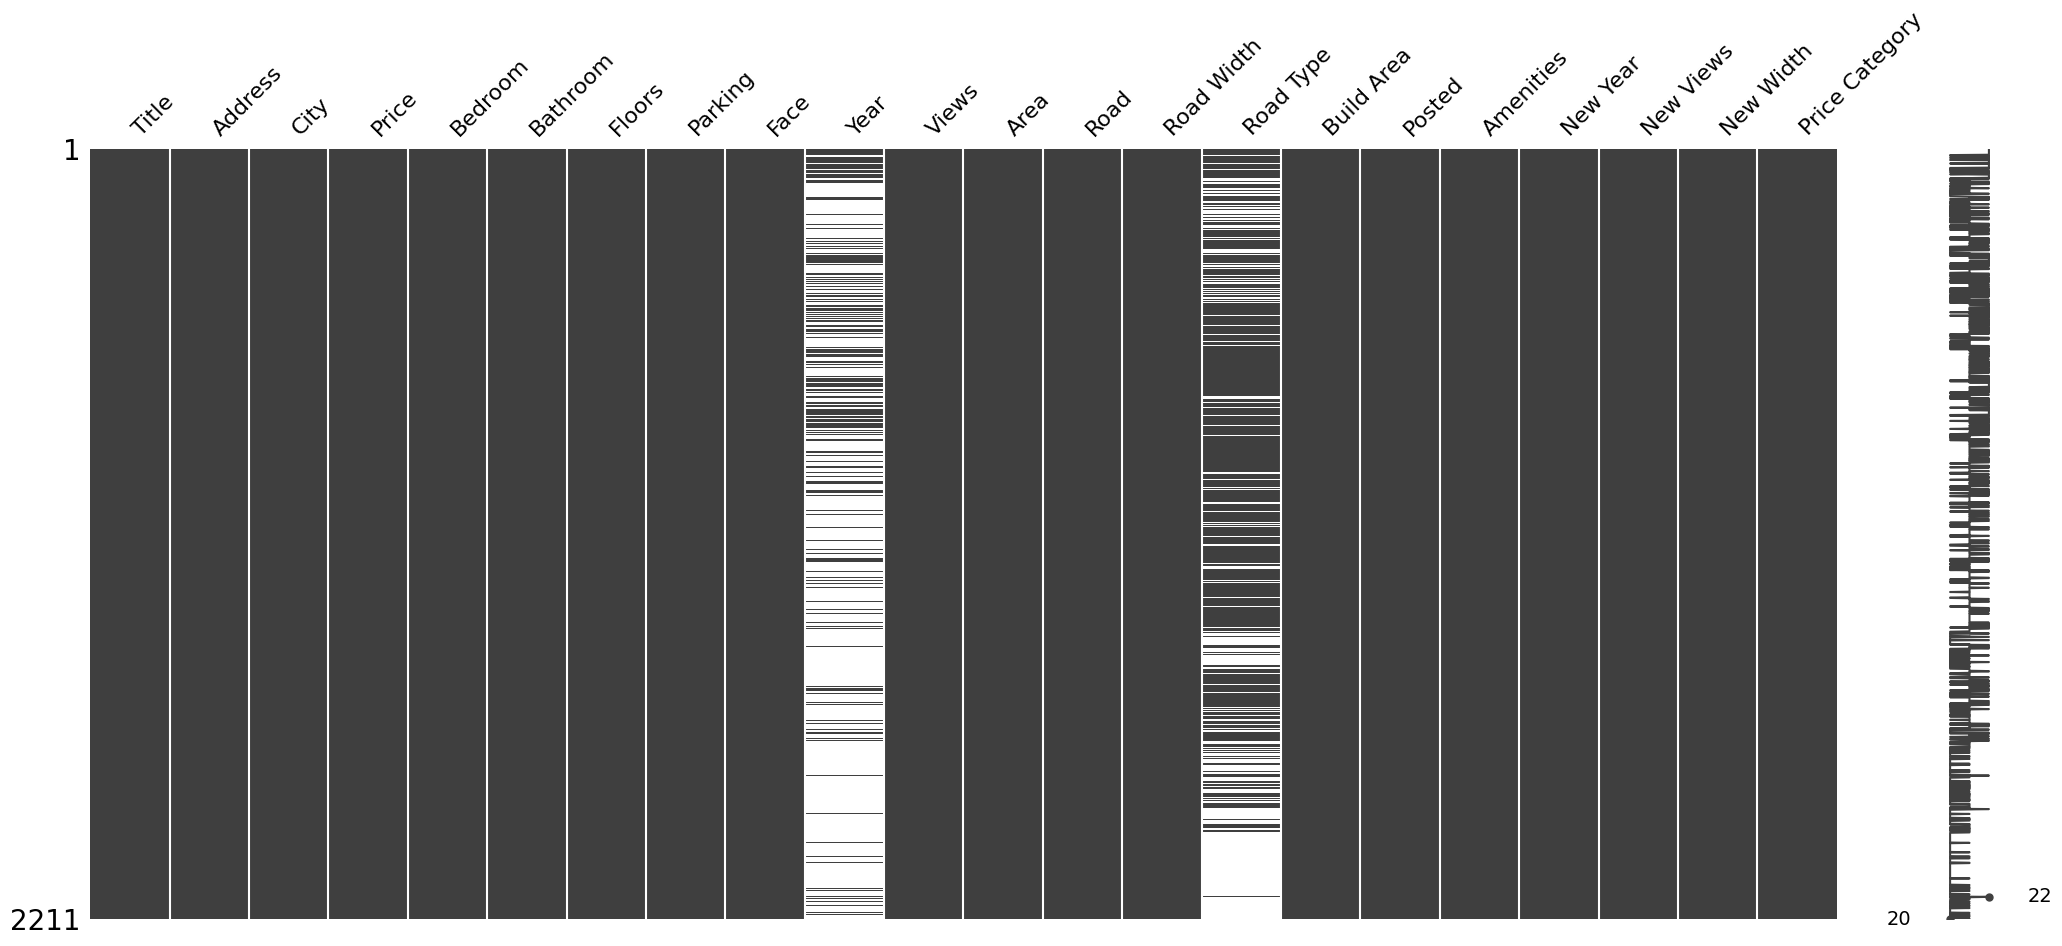

In [427]:
floor_mean = int(data['Floors'].mean())

data_imputed_floor = data.fillna({'Floors': floor_mean})

msno.matrix(data_imputed_floor)

In [428]:
print(data['New Year'].min())

mean_new_year = int(data['Year'].mean())
print(data[data['Year'].isna()])

0
                                                  Title  \
17    2.5 Storey House On Sale At Daura Dipo , Check...   
18    House For Sale At Kalanki : House For Sale In ...   
19    House Sale In Lolang Height : House For Sale I...   
21             House For Sale In Radhe Radhe, Bhaktapur   
25    Dhapasi Deurali Janata Najik Ghar : House For ...   
...                                                 ...   
2205         Land For Sale In Budhanilkantha, Kathmandu   
2206               House For Rent In Chapali, Kathmandu   
2207             House For Sale In Sitapaila, Kathmandu   
2209             House For Rent In Baneshwor, Kathmandu   
2210             House For Sale In Baluwatar, Kathmandu   

                                     Address       City     Price  Bedroom  \
17            Daura Dipo, Thankot, Kathmandu  Kathmandu  18500000        4   
18           khasibazaar, Kalanki, Kathmandu  Kathmandu  62000000        7   
19      Lonag height, Kavresthali, Kathmandu  Kathmandu

In [429]:
print(data_imputed_floor['Road Type'].value_counts())
data_imputed_incomplete = data_imputed_floor
data_imputed_floor['Road Type'].str.strip()

cols = ['Price', 'Year', 'Bathroom', 'Floors', 'Parking']

data_imputed_incomplete_groups = data_imputed_incomplete.groupby('Road Type')[cols].agg(np.mean)

print(data_imputed_incomplete_groups)
print(data_imputed_incomplete['Road Type'].value_counts(dropna=False))


Road Type
Blacktopped        749
Gravelled          404
Soil Stabilized    167
Paved               77
Concrete            25
Alley                4
Name: count, dtype: int64
                        Price         Year  Bathroom    Floors   Parking
Road Type                                                               
Alley            6.850000e+06  2025.333333  3.000000  3.000000  0.750000
Blacktopped      2.258698e+07  2056.989209  4.078772  2.490654  0.767690
Concrete         1.617708e+07  2069.076923  3.520000  2.380000  0.640000
Gravelled        1.544149e+07  2063.616352  3.663366  2.266955  0.556931
Paved            1.980455e+07  2048.093023  3.896104  2.662338  1.051948
Soil Stabilized  1.036647e+07  2054.857143  3.790419  2.011976  0.287425
Road Type
NaN                 785
 Blacktopped        749
 Gravelled          404
 Soil Stabilized    167
 Paved               77
 Concrete            25
 Alley                4
Name: count, dtype: int64


C:\Users\swoye\AppData\Local\Temp\ipykernel_3420\604239626.py:7: FutureWarning: The provided callable <function mean at 0x000002337ED39620> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  data_imputed_incomplete_groups = data_imputed_incomplete.groupby('Road Type')[cols].agg(np.mean)


In [430]:
data_imputed_incomplete.loc[
    (data_imputed_incomplete['Road Type'].isna()) & (data_imputed_incomplete['Year'] <= 2025), 
    'Road Type'
] = "Alley"


data_imputed_incomplete['Road Type'] = data_imputed_incomplete['Road Type'].str.strip()
print(data_imputed_incomplete['Road Type'].value_counts(dropna=False))

Road Type
NaN                766
Blacktopped        749
Gravelled          404
Soil Stabilized    167
Paved               77
Concrete            25
Alley               23
Name: count, dtype: int64


In [431]:
data_imputed_incomplete.loc[
    (data_imputed_incomplete['Road Type'].isna()) & (data_imputed_incomplete['Year'] > 2025) & (data_imputed_incomplete['Year'] <= 2050), 
    'Road Type'
] = "Paved"

print(data_imputed_incomplete['Road Type'].value_counts(dropna=False))

Road Type
NaN                765
Blacktopped        749
Gravelled          404
Soil Stabilized    167
Paved               78
Concrete            25
Alley               23
Name: count, dtype: int64


In [432]:
data_imputed_incomplete.loc[
    (data_imputed_incomplete['Road Type'].isna()) & (data_imputed_incomplete['Year'] > 2050) & (data_imputed_incomplete['Year'] <= 2060), 
    'Road Type'
] = "Blacktopped"

print(data_imputed_incomplete['Road Type'].value_counts(dropna=False))

Road Type
NaN                763
Blacktopped        751
Gravelled          404
Soil Stabilized    167
Paved               78
Concrete            25
Alley               23
Name: count, dtype: int64


In [433]:
data_imputed_incomplete.loc[
    (data_imputed_incomplete['Road Type'].isna()) & (data_imputed_incomplete['Year'] > 2060) & (data_imputed_incomplete['Year'] <= 2065), 
    'Road Type'
] = "Gravelled"

print(data_imputed_incomplete['Road Type'].value_counts(dropna=False))

Road Type
NaN                761
Blacktopped        751
Gravelled          406
Soil Stabilized    167
Paved               78
Concrete            25
Alley               23
Name: count, dtype: int64


In [434]:
data_imputed_incomplete.loc[
    (data_imputed_incomplete['Road Type'].isna()) & (data_imputed_incomplete['Year'] > 2065), 
    'Road Type'
] = "Concrete"

print(data_imputed_incomplete['Road Type'].value_counts(dropna=False))

Road Type
Blacktopped        751
NaN                727
Gravelled          406
Soil Stabilized    167
Paved               78
Concrete            59
Alley               23
Name: count, dtype: int64


In [435]:
data_imputed_incomplete.loc[
    (data_imputed_incomplete['Road Type'].isna()) & (data_imputed_incomplete['Parking'] >= 1), 
    'Road Type'
] = "Paved"

print(data_imputed_incomplete['Road Type'].value_counts(dropna=False))

Road Type
Blacktopped        751
NaN                514
Gravelled          406
Paved              291
Soil Stabilized    167
Concrete            59
Alley               23
Name: count, dtype: int64


In [436]:
data_imputed_incomplete.loc[
    (data_imputed_incomplete['Road Type'].isna()) & (data_imputed_incomplete['Parking'] <= 0.5), 
    'Road Type'
] = "Soil Stabilized"

print(data_imputed_incomplete['Road Type'].value_counts(dropna=False))
print(data_imputed_incomplete['Parking'].max())
cleanData = data_imputed_incomplete

Road Type
Blacktopped        751
Soil Stabilized    681
Gravelled          406
Paved              291
Concrete            59
Alley               23
Name: count, dtype: int64
2


<Axes: >

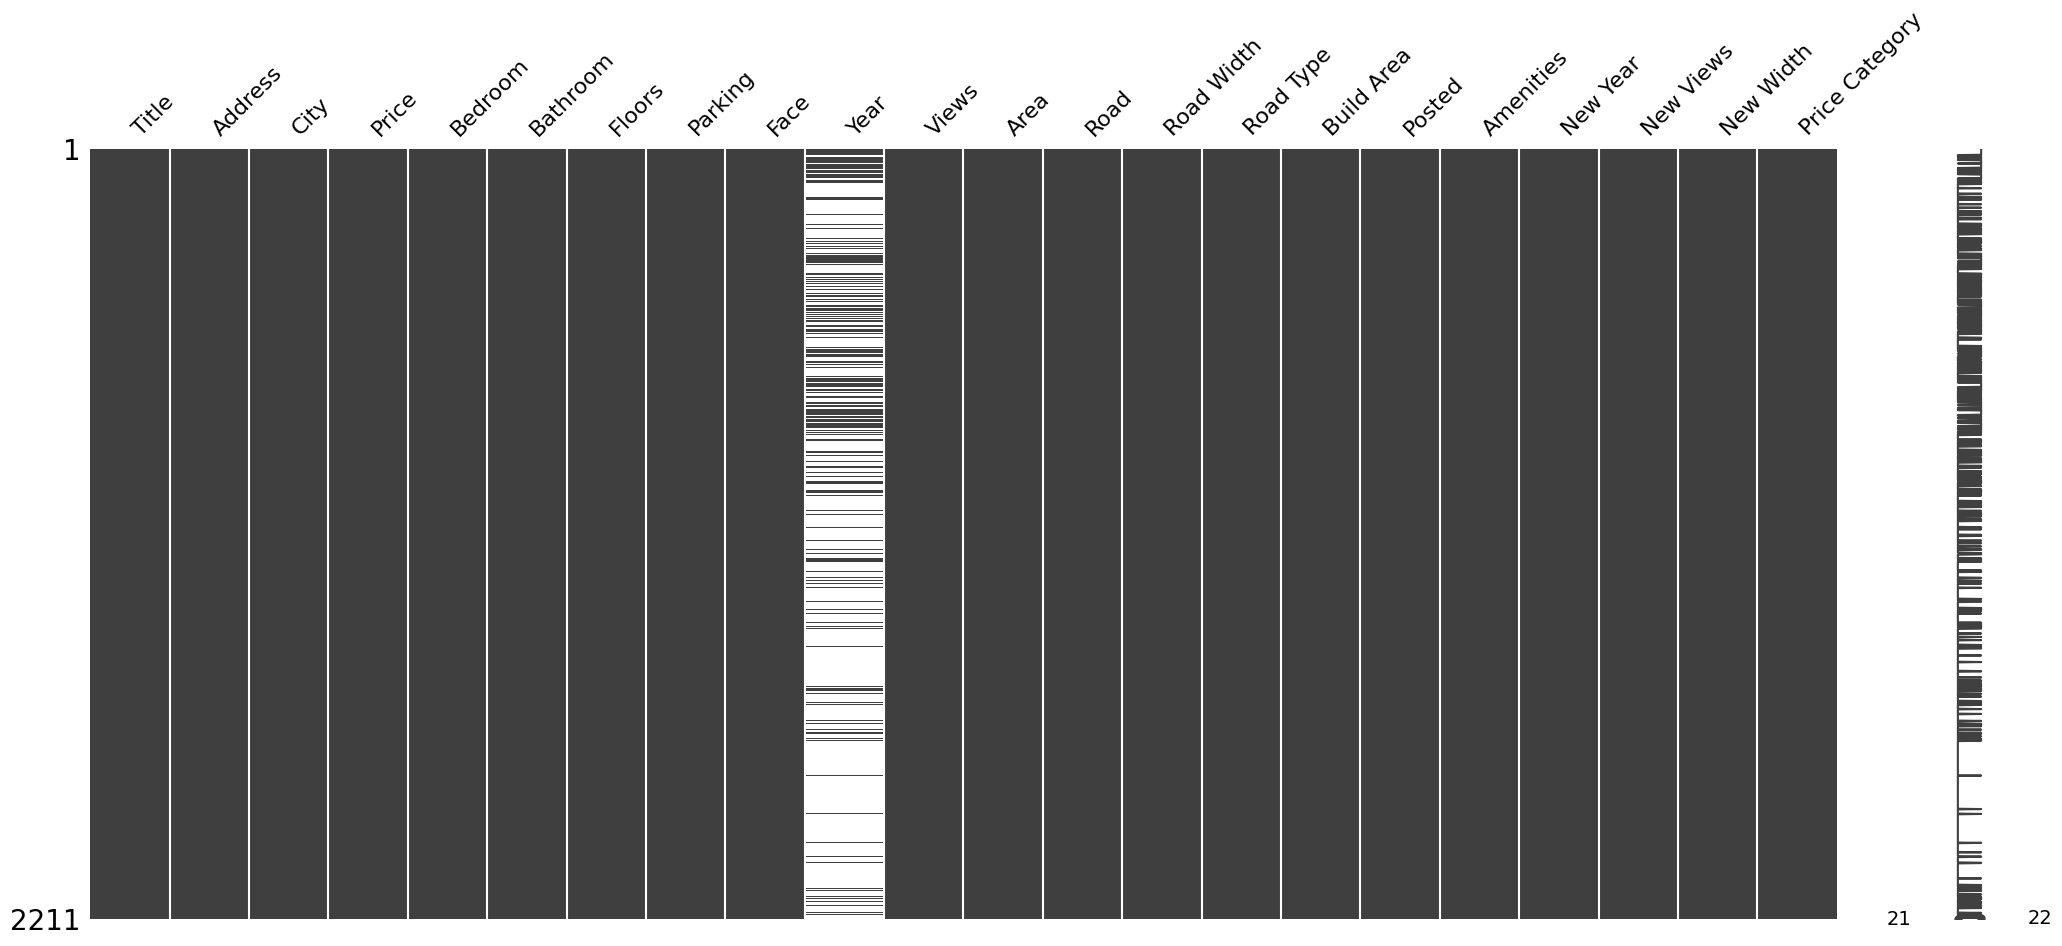

In [437]:
msno.matrix(data_imputed_incomplete)

In [438]:
first_ct = pd.crosstab(cleanData['City'], cleanData['Road Width'], margins=True)

print(first_ct)

Road Width   0 Feet  0 Feet   0 Meter   1 Feet  1 Feet   1 Meter   10 Feet  \
City                                                                         
Bara              0        1         0       0        0         0        0   
Bardiya           0        0         0       0        0         0        0   
Bhairahawa        0        0         0       0        0         0        0   
Bhaktapur         5        1         0       0        0         0        2   
Biratnagar        1        1         0       0        0         0        0   
Birtamod          0        0         0       0        0         0        0   
Butwal            1        0         0       0        0         0        0   
Chitwan           0        0         0       0        0         0        0   
Dang              1        0         0       0        0         0        0   
Dhading           0        0         0       0        0         0        0   
Dharan            0        0         1       0        0         

The city with the most houses available!!

In [439]:
popularCity = cleanData['City'].value_counts().index[0]

The highest priced house in each city!!

In [440]:
priceDf = cleanData.groupby('City')['Price'].max()

print(priceDf)

City
Bara            1300000
Bardiya         3650000
Bhairahawa     64300000
Bhaktapur      64300000
Biratnagar      8000000
Birtamod        1300000
Butwal         25000000
Chitwan        64300000
Dang            1300000
Dhading        62000000
Dharan         12500000
Illam           1850000
Itahari         1300000
Jhapa          20000000
Kailali         6700000
Kapilvastu     37000000
Kaski          64300000
Kathmandu      64300000
Kavre          15200000
Kirtipur       59000000
Lalitpur       64300000
Mahottari       1300000
Makwanpur      20000000
Morang          1300000
Nawalparasi     2200000
Nawalpur       11000000
Parsa           4500000
Pokhara        64300000
Rupandehi       1300000
Sunsari        15000000
Surkhet        20000000
Tanahu         15000000
Name: Price, dtype: int64


In [441]:
print(cleanData['Area'])

0        1-0-0-0 Aana
1       0-21-0-0 Aana
2        1-1-0-0 Aana
3       0-10-1-0 Aana
4       0-19-2-0 Aana
            ...      
2206         1 Ropani
2207         2.5 Aana
2208           8 Aana
2209          51 Aana
2210          13 Aana
Name: Area, Length: 2211, dtype: object


Maximum of various departments of house based on cities!!

In [442]:
maxDF = cleanData.groupby('City')[['Price', 'Bedroom', 'Bathroom', 'Floors', 'Parking']].max()

print(maxDF)

                Price  Bedroom  Bathroom  Floors  Parking
City                                                     
Bara          1300000        1         4     2.0        0
Bardiya       3650000        4         1     2.0        0
Bhairahawa   64300000       12        10     3.0        1
Bhaktapur    64300000       12         4     5.0        2
Biratnagar    8000000        3         4     2.0        1
Birtamod      1300000        1         4     2.0        0
Butwal       25000000       10         4     3.0        2
Chitwan      64300000       12         6     3.0        2
Dang          1300000        1         4     2.0        0
Dhading      62000000        4         4     2.0        0
Dharan       12500000        1         4     2.0        0
Illam         1850000        1         4     0.0        0
Itahari       1300000        1         4     2.0        0
Jhapa        20000000        4         4     4.0        2
Kailali       6700000        1         4     2.0        0
Kapilvastu   3

In [443]:
print(cleanData.columns)

Index(['Title', 'Address', 'City', 'Price', 'Bedroom', 'Bathroom', 'Floors',
       'Parking', 'Face', 'Year', 'Views', 'Area', 'Road', 'Road Width',
       'Road Type', 'Build Area', 'Posted', 'Amenities', 'New Year',
       'New Views', 'New Width', 'Price Category'],
      dtype='object')


Cross Tabulation on City and Price Category

In [444]:
cityXprice = pd.crosstab(cleanData['City'], cleanData['Price Category'])

print(cityXprice)

Price Category  High  Low  Medium
City                             
Bara               0    0       4
Bardiya            0    1       0
Bhairahawa         1    0       0
Bhaktapur         48    1      36
Biratnagar         1    0       5
Birtamod           0    0       1
Butwal             2    0       4
Chitwan           21    2      10
Dang               0    0       1
Dhading            3    0       1
Dharan             6    0       5
Illam              1    0       0
Itahari            0    0       3
Jhapa              5    0       5
Kailali            1    0       0
Kapilvastu         1    0       0
Kaski              1    0       2
Kathmandu       1051   15     417
Kavre              3    0       4
Kirtipur           6    0       1
Lalitpur         218    9     205
Mahottari          0    0       1
Makwanpur          4    0       8
Morang             0    0       4
Nawalparasi        3    0       9
Nawalpur           1    0       0
Parsa              2    0       2
Pokhara       

Cross Tabulation on City and Road Type

In [445]:
cityXroad = pd.crosstab(cleanData['City'], cleanData['Road Type'])

print(cityXroad)

Road Type    Alley  Blacktopped  Concrete  Gravelled  Paved  Soil Stabilized
City                                                                        
Bara             0            0         0          0      0                4
Bardiya          0            0         0          0      0                1
Bhairahawa       0            0         0          0      1                0
Bhaktapur        0           29         1         18      3               34
Biratnagar       0            2         0          3      0                1
Birtamod         0            0         0          0      0                1
Butwal           1            2         0          2      0                1
Chitwan          1           15         1          7      2                7
Dang             0            0         0          0      0                1
Dhading          0            0         0          1      0                3
Dharan           0            6         0          3      1                1

In [446]:
cleanData['Price'].describe()

count    2.211000e+03
mean     1.713892e+07
std      1.920312e+07
min      1.300000e+06
25%      1.300000e+06
50%      8.000000e+06
75%      2.650000e+07
max      6.430000e+07
Name: Price, dtype: float64

In [447]:
print(cleanData['Price'].value_counts())

Price
1300000     563
64300000    142
3500000      35
25000000     33
2500000      32
           ... 
6800000       1
5100000       1
4550000       1
11700000      1
59000000      1
Name: count, Length: 229, dtype: int64


In [448]:
print(cleanData['City'].unique())

['Kathmandu' 'Lalitpur' 'Pokhara' 'Bhaktapur' 'Chitwan' 'Butwal' 'Bara'
 'Birtamod' 'Dharan' 'Sunsari' 'Makwanpur' 'Nawalpur' 'Kirtipur'
 'Biratnagar' 'Parsa' 'Itahari' 'Jhapa' 'Mahottari' 'Dhading' 'Bardiya'
 'Morang' 'Dang' 'Kavre' 'Kaski' 'Surkhet' 'Bhairahawa' 'Kapilvastu'
 'Rupandehi' 'Tanahu' 'Illam' 'Nawalparasi' 'Kailali']


Price is most positively correlated with Bedroom

In [449]:
print(cleanData['Price'].corr(cleanData['Bedroom']))

0.4158192274533373


In [450]:
cleanData.columns

Index(['Title', 'Address', 'City', 'Price', 'Bedroom', 'Bathroom', 'Floors',
       'Parking', 'Face', 'Year', 'Views', 'Area', 'Road', 'Road Width',
       'Road Type', 'Build Area', 'Posted', 'Amenities', 'New Year',
       'New Views', 'New Width', 'Price Category'],
      dtype='object')

## Updated cleanData

In [451]:
def statCal(data):
    return round(data.mean(), 2), data.median(), np.quantile(data, 0.25), np.quantile(data, 0.75)

Area Update

In [452]:
def calculate_new_area(row):
    # Handling area with a hyphen (e.g., '16-6-2-1')
    if isinstance(row['Area'], str) and "-" in row['Area']:
        parts = row['Area'].split("-")
        newarea = 0

        if len(parts) > 0 and parts[0].isdigit(): 
            newarea += 16 * float(parts[0])
        if len(parts) > 1 and parts[1].isdigit(): 
            newarea += float(parts[1])
        if len(parts) > 2 and parts[2].isdigit():
            newarea += float(parts[2]) / 4
        if len(parts) > 3 and parts[3].isdigit():
            newarea += float(parts[3]) / 16

        return f"{newarea} Aana"
    
    # Handling area in Ropani
    elif isinstance(row['Area'], str) and ("Ropani" in row['Area'] or "ropani" in row['Area'] or "r" in row['Area']):
        parts = row['Area'].split(" ")
        newarea = 0

        if len(parts) == 2 and parts[0].isdigit():
            newarea = 16 * float(parts[0])

        return f"{newarea} Aana"
    
    # Handling area in Sq. Feet
    elif isinstance(row['Area'], str) and "Sq. Feet" in row['Area']:
        parts = row['Area'].split(" ")
        newarea = 0

        if len(parts) == 3 and parts[0].isdigit():
            newarea = float(parts[0]) / 342.25

        return f"{round(newarea, 2)} Aana"
    
    # Handling area in Dhur
    elif isinstance(row['Area'], str) and "Dhur" in row['Area']:
        parts = row['Area'].split(" ")
        newarea = 0

        if len(parts) == 2 and parts[0].isdigit():
            newarea = float(parts[0]) * 0.0625

        return f"{round(newarea, 2)} Aana"
    
    # Handling area in Kattha
    elif isinstance(row['Area'], str) and "Kattha" in row['Area']:
        parts = row['Area'].split(" ")
        newarea = 0

        if len(parts) == 2 and parts[0].isdigit():
            newarea = float(parts[0]) * 4

        return f"{round(newarea, 2)} Aana"
    
    # Handling area in Aman
    elif isinstance(row['Area'], str) and "Aman" in row['Area']:
        parts = row['Area'].split(" ")
        newarea = 0

        if len(parts) == 2 and parts[0].isdigit():
            newarea = float(parts[0]) * 20

        return f"{round(newarea, 2)} Aana"
    
    # Handling area in Bigha
    elif isinstance(row['Area'], str) and "Bigha" in row['Area']:
        parts = row['Area'].split(" ")
        newarea = 0

        if len(parts) == 2 and parts[0].isdigit():
            newarea = float(parts[0]) * 80

        return f"{round(newarea, 2)} Aana"
    
    # Handling area in Haat
    elif isinstance(row['Area'], str) and "Haat" in row['Area']:
        parts = row['Area'].split(" ")
        newarea = 0
        
        if len(parts) == 2 and parts[0].isdigit() and len(parts) > 1 and parts[1] == "Haat":
            area_in_feet = float(parts[0]) * 1.5
            newarea = area_in_feet / 306.25
            
        return f"{round(newarea, 2)} Aana"
    
    # Handling area in Anand
    elif isinstance(row['Area'], str) and "Anand" in row['Area']:
        parts = row['Area'].split(" ")
        
        newarea = parts[0]
            
        return f"{newarea, 2} Aana"
    
    # Handling area in decimal format (e.g., '12.25')
    if isinstance(row['Area'], str) and "." in row['Area']:
        main_parts = row['Area'].split(".")
        if len(main_parts) > 2:
            main_parts = main_parts[:2]
        try:
            newarea = float(main_parts[0] + "." + main_parts[1])
            return f"{newarea} Aana"
        except ValueError:
            pass

    # Return the original value if no conversion applies
    return row.iloc[11]

# Final processing of the area data
def final_area(row):
    # Convert tuple to float if necessary
    if isinstance(row, tuple):
        try:
            row = float(f"{row[0]}.{row[1]}")
        except ValueError:
            row = None
    # Clean up the 'Aana' string and convert to float
    elif isinstance(row, str):
        try:
            row = float(row.replace(' ana Aana', '').replace(' Aana', '').replace('aana', '').strip())
        except ValueError:
            row = None
    return row

cleanData['NewArea(Aana)'] = cleanData.apply(calculate_new_area, axis=1)
cleanData['NewArea(Aana)'] = cleanData['NewArea(Aana)'].apply(final_area)

cleanData['NewArea(Aana)'] = cleanData['NewArea(Aana)'].fillna(cleanData['NewArea(Aana)'].median())


In [453]:
area_mean, area_md, area_q1, area_q3 = statCal(cleanData['NewArea(Aana)'])

area_iqr = np.quantile(cleanData['NewArea(Aana)'], 0.75) - np.quantile(cleanData['NewArea(Aana)'], 0.25)
area_upper = np.quantile(cleanData['NewArea(Aana)'], 0.75) + 1.5 * area_iqr
area_lower = np.quantile(cleanData['NewArea(Aana)'], 0.075)

In [454]:
cleanData.loc[cleanData['NewArea(Aana)'] < area_lower, 'NewArea(Aana)'] = area_lower
cleanData.loc[cleanData['NewArea(Aana)'] > area_upper, 'NewArea(Aana)'] = area_upper

farea_mean, farea_md, farea_q1, farea_q3 = statCal(cleanData['NewArea(Aana)'])

In [455]:
bath_mean, bath_median, bath_q1, bath_q3 = statCal(cleanData['Bathroom'])
bed_mean, bed_median, bed_q1, bed_q3 = statCal(cleanData['Bedroom'])
park_mean, park_median, park_q1, park_q3 = statCal(cleanData['Parking'])
price_mean, price_median, price_q1, price_q3 = statCal(cleanData['Price'])

print(price_q3)


26500000.0


In [456]:
price_mean = int(cleanData['Price'].mean())
dropped_year = cleanData.dropna(subset='Year')
lower_year = np.quantile(dropped_year['Year'], 0.025)
year_available = dropped_year['Year'].describe()
year_mean_available, year_md_available, year_q1_available, year_q3_available = statCal(dropped_year['Year'])

cleanData.loc[((cleanData['Year'] >= year_md_available) & (cleanData['Year'] < 2079)) & ((cleanData['Bathroom'] >= 4) & (cleanData['Bathroom'] < 10)) & ((cleanData['Parking'] == 1)), 'Price'] = 26500000
cleanData.loc[((cleanData['Year'] > float(year_mean_available))) & ((cleanData['Price'] == 1300000)) & ((cleanData['Bathroom'] >= 4) & (cleanData['Bathroom'] < 10) | (cleanData['Parking'] >= 0)), 'Price'] = price_mean

Year Update

In [457]:
for index, row in cleanData.iterrows():
    if pd.isna(row['Year']):
        if (((row['Bathroom'] <= bath_q1) | (row['Bedroom'] <= bed_q1) | (row['Parking'] <= park_q1)) & (row['Price'] <= price_q1)):
            cleanData.iloc[index, 9] = int((year_q1_available + dropped_year['Year'].min())/2)
        elif ((((row['Bathroom'] > bath_q1) & (row['Bathroom'] <= bath_median)) | ((row['Bedroom'] > bed_q1) & (row['Bedroom'] <= bed_median)) | ((row['Parking'] > park_q1) & (row['Parking'] <= park_median))) & ((row['Price'] > price_q1) & (row['Price'] <= price_median))):
            cleanData.iloc[index, 9] = int((year_q1_available + year_md_available)/2)
        elif ((((row['Bathroom'] > bath_median) & (row['Bathroom'] <= bath_q3)) | ((row['Bedroom'] > bed_median) & (row['Bedroom'] <= bed_q3)) | ((row['Parking'] > park_median) & (row['Parking'] <= park_q3))) & ((row['Price'] > price_median) & (row['Price'] <= price_q3))):
            cleanData.iloc[index, 9] = int((year_q3_available + year_md_available)/2)
        elif (((row['Bathroom'] > bath_q3) | (row['Bedroom'] > bed_q3) | (row['Parking'] > park_q3)) & (row['Price'] > price_q3)):
            cleanData.iloc[index, 9] = int((year_q3_available + dropped_year['Year'].max())/2)

cleanData['Year'] = cleanData['Year'].fillna(int(year_mean_available))
print(cleanData.isna().sum())

Title             0
Address           0
City              0
Price             0
Bedroom           0
Bathroom          0
Floors            0
Parking           0
Face              0
Year              0
Views             0
Area              0
Road              0
Road Width        0
Road Type         0
Build Area        0
Posted            0
Amenities         0
New Year          0
New Views         0
New Width         0
Price Category    0
NewArea(Aana)     0
dtype: int64


In [458]:
date_mean_price = int(cleanData[(cleanData['Year'] > 2040) & (cleanData['Year'] < 2060)][ 'Price'].mean())
date_md_price = int(np.quantile(cleanData[(cleanData['Year'] > 2040) & (cleanData['Year'] < 2060)]['Price'], 0.5))
date_md_bath = int(np.quantile(cleanData[(cleanData['Year'] > 2040) & (cleanData['Year'] < 2060)]['Bathroom'], 0.5))
date_md_bed = int(np.quantile(cleanData[(cleanData['Year'] > 2040) & (cleanData['Year'] < 2060)]['Bedroom'], 0.5))
date_md_park = int(np.quantile(cleanData[(cleanData['Year'] > 2040) & (cleanData['Year'] < 2060)]['Parking'], 0.5))


In [459]:
cleanData.loc[(cleanData['Year'] <= year_q3_available) & (cleanData['NewArea(Aana)'] < farea_q3) & (cleanData['NewArea(Aana)'] >= farea_md) & (cleanData['Price'] > price_mean), 'Price'] = int(price_mean)
cleanData.loc[(cleanData['Year'] <= year_md_available) & (cleanData['NewArea(Aana)'] <= farea_md) & (cleanData['NewArea(Aana)'] >= farea_q1) & (cleanData['Price'] > price_median), 'Price'] = int(price_median)
cleanData.loc[(cleanData['Year'] > year_md_available) & (cleanData['NewArea(Aana)'] <= farea_md) & (cleanData['NewArea(Aana)'] >= farea_q1) & (cleanData['Price'] > price_q3), 'Price'] = price_q3
cleanData.loc[(cleanData['Year'] > year_md_available) & (cleanData['NewArea(Aana)'] > farea_q3) & (cleanData['Price'] < np.quantile(cleanData['Price'], 0.95)), 'Price'] = np.quantile(cleanData['Price'], 0.95)
cleanData.loc[(cleanData['Year'] > year_q3_available) & (cleanData['NewArea(Aana)'] > farea_mean) & (cleanData['Price'] < np.quantile(cleanData['Price'], 0.955)), 'Price'] = np.quantile(cleanData['Price'], 0.955)
cleanData.loc[(cleanData['Year'] >= year_mean_available) & (cleanData['Year'] < year_md_available) & (cleanData['NewArea(Aana)'] > farea_q3) & (cleanData['Price'] < price_q3), 'Price'] = price_q3
cleanData.loc[(cleanData['Year'] > year_q1_available) & (cleanData['Year'] < year_mean_available) & (cleanData['NewArea(Aana)'] > farea_q3) & (cleanData['Price'] < price_median), 'Price'] = price_median

print(farea_md)

print(cleanData[(cleanData['Price'] < price_mean) & (cleanData['NewArea(Aana)'] > 10) & (cleanData['Year'] < year_mean_available)][['Price', 'Year', 'NewArea(Aana)', 'City']])

5.0
         Price    Year  NewArea(Aana)       City
6     11000000  2019.0          19.75   Lalitpur
101    8000000  2057.0          12.00  Kathmandu
102    8000000  2057.0          18.00  Kathmandu
109    8000000  2057.0          18.00  Kathmandu
110    8000000  2057.0          18.00  Kathmandu
...        ...     ...            ...        ...
2194   8000000  2057.0          19.75  Kathmandu
2204   8000000  2057.0          19.75   Lalitpur
2205   8000000  2057.0          19.75  Kathmandu
2206   8000000  2057.0          16.00  Kathmandu
2209   1300000  2007.0          19.75  Kathmandu

[344 rows x 4 columns]


In [460]:
cleanData.loc[(cleanData['Year'] < 2060) & (cleanData['Year'] > 2040) & ((cleanData['Bedroom'] <= date_md_bed) | (cleanData['Bathroom'] <= date_md_bath) | (cleanData['Parking'] <= date_md_park)) & (cleanData['Price'] >= date_mean_price), 'Price'] = date_mean_price


In [461]:
cleanData.loc[(cleanData['Year'] < 2040) & (cleanData['Year'] > 2020) & ((cleanData['Bedroom'] <= bed_median) | (cleanData['Bathroom'] <= bath_median) | (cleanData['Parking'] <= park_median)) & (cleanData['Price'] >= price_median), 'Price'] = price_median

In [462]:
cleanData.loc[(cleanData['Price'] == 1300000) & (cleanData['Bathroom'] > 4), 'Bathroom'] = 4

## Outliers Analysis

## Outliers analysis Bedroom

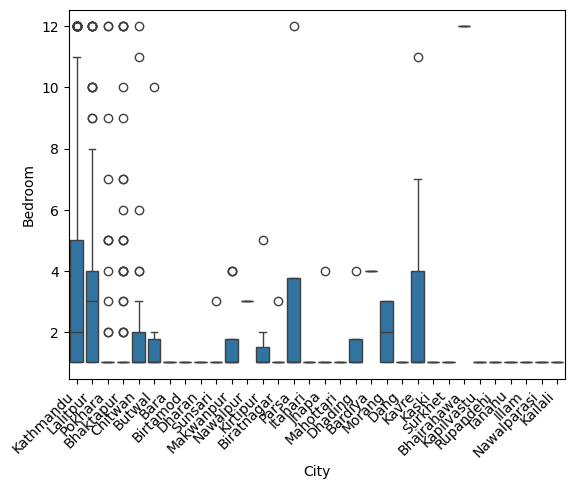

In [463]:
sns.boxplot(x = 'City', y = 'Bedroom', data = cleanData)
plt.xticks(rotation = 45, ha = 'right')
plt.show()

In [464]:
print(np.median(cleanData['Price']))
cleanData.loc[(cleanData['Bedroom'] <= np.quantile(cleanData['Bedroom'], 0.25)) & (cleanData['Bathroom'] <= np.quantile(cleanData['Bathroom'], 0.25)) & (cleanData['Parking'] <= np.quantile(cleanData['Parking'], 0.25)) & (cleanData['Floors'] <= np.quantile(cleanData['Floors'], 0.25)), 'Price'] = np.median(cleanData['Price']) 

8000000.0


Kathmandu

In [465]:
bedroom_data_ktm = cleanData[cleanData['City'] == "Kathmandu"][['Bedroom']]
bed_ktm_iqr = np.quantile(bedroom_data_ktm, 0.75) - np.quantile(bedroom_data_ktm, 0.25)
bedroom_limit_ktm = np.quantile(bedroom_data_ktm, 0.75) + bed_ktm_iqr * 1.5

cleanData.loc[(cleanData['City'] == "Kathmandu") & (cleanData['Bedroom'] >= bedroom_limit_ktm), 'Bedroom'] = bedroom_limit_ktm

print(cleanData.loc[cleanData['City'] == "Kathmandu", 'Bedroom'].max())

11


Lalitpur

In [466]:
lalit_price = np.quantile(cleanData[cleanData['City'] == "Lalitpur"]['Price'], 0.25)
cleanData.loc[(cleanData['City'] == "Lalitpur") & (cleanData['Price'] <= lalit_price), 'Bedroom'] = 1
bedroom_data_lalit = cleanData[cleanData['City'] == "Lalitpur"][['Bedroom']]
bed_lalit_iqr = np.quantile(bedroom_data_lalit, 0.75) - np.quantile(bedroom_data_lalit, 0.25)
bedroom_limit_lalit = int(np.quantile(bedroom_data_lalit, 0.75) + bed_lalit_iqr * 1.5)

cleanData.loc[(cleanData['City'] == "Lalitpur") & (cleanData['Bedroom'] >= bedroom_limit_lalit), 'Bedroom'] = bedroom_limit_lalit


Pokhara

In [467]:
cleanData.loc[cleanData['Price'] <= 8000000, 'Bedroom'] = 1
new_bedroom_pokhara = cleanData[(cleanData['City'] == "Pokhara") & (cleanData['Price'] == 64300000)]['Bedroom'].max()
cleanData.loc[(cleanData['Bedroom'] >= new_bedroom_pokhara) & (cleanData['City'] == "Pokhara"), 'Bedroom'] = new_bedroom_pokhara

Bhaktapur

In [468]:
cleanData.loc[(cleanData['City'] == "Bhaktapur") & (cleanData['Price'] < 64300000), 'Bedroom'] = 1
cleanData.loc[(cleanData['City'] == "Bhaktapur") & (cleanData['Price'] == 64300000), 'Bedroom'] = 9


Chitwan

In [469]:
chitwan_bedroom = cleanData[cleanData['City'] == "Chitwan"]['Bedroom'].max()
print(cleanData[(cleanData['City'] == "Chitwan") & (cleanData['Bedroom'] == 9)][['Price', 'Year', 'Bathroom']])

cleanData.loc[(cleanData['City'] == 'Chitwan') & (cleanData['Bedroom'] == 9) & (cleanData['Year'] > 2019.0), 'Bedroom'] = 4

cleanData.loc[(cleanData['City'] == "Butwal") & (cleanData['Bedroom'] > bed_q3), 'Price'] = price_q3

Empty DataFrame
Columns: [Price, Year, Bathroom]
Index: []


Butwal

In [470]:
cleanData.loc[(cleanData['City'] == "Butwal") & (cleanData['Bedroom'] > bed_q3), 'Price'] = price_q3
cleanData.loc[cleanData['City'] == "Butwal"][['Price', 'Bedroom', 'Bathroom', 'Price', 'Year', 'NewArea(Aana)']]

,Price,Bedroom,Bathroom,Price,Year,NewArea(Aana)
83,1300000,1,1,1300000,2020.0,1.46
343,8000000,1,4,8000000,2007.0,1.46
378,1300000,1,2,1300000,2014.0,19.75
846,8000000,1,4,8000000,2057.0,1.46
1377,8000000,1,4,8000000,2007.0,19.75
1923,26500000,10,4,26500000,2057.0,19.75


Butwal

Kavre

In [471]:
kavre_bedroom = cleanData[cleanData['City'] == "Kavre"]['Bedroom'].max()
print(cleanData[(cleanData['City'] == "Kavre") & (cleanData['Bedroom'] == kavre_bedroom)][['Price', 'Year']])

         Price    Year
1525  15200000  2018.0


## Outliers analysis Bathroom

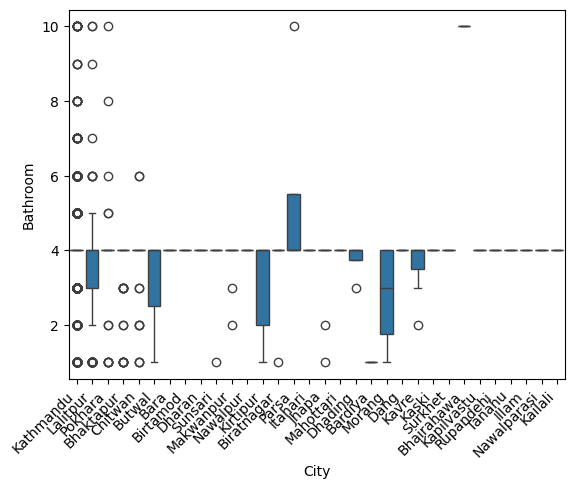

In [472]:
sns.boxplot(x = 'City', y = 'Bathroom', data = cleanData)
plt.xticks(rotation = 45, ha = 'right')
plt.show()

Kathmandu

In [473]:
print(cleanData[cleanData['City'] == "Kathmandu"]['Price'].describe())

print(cleanData[(cleanData['City'] == "Kathmandu") & (cleanData['Bathroom'] > 4)][['Price', 'Parking', 'Year', 'Bathroom']])

print(cleanData[(cleanData['City'] == "Kathmandu") & (cleanData['Price'] == 1300000)][['Bathroom', 'Parking', 'Year']])
print(cleanData[(cleanData['City'] == "Kathmandu") & (cleanData['Bathroom'] == 10)][['Price', 'Year', 'Parking']])

bathroom_CI_ktm = int(np.quantile(cleanData[cleanData['City'] == "Kathmandu"]['Bathroom'], 0.975))

cleanData.loc[(cleanData['City'] == "Kathmandu") & (cleanData['Bathroom'] > bathroom_CI_ktm), 'Bathroom'] = bathroom_CI_ktm

count    1.483000e+03
mean     1.533248e+07
std      1.527879e+07
min      1.300000e+06
25%      8.000000e+06
50%      8.000000e+06
75%      1.713892e+07
max      6.430000e+07
Name: Price, dtype: float64
         Price  Parking    Year  Bathroom
5     64300000        2  2074.0         6
8     64300000        2  2017.0         8
13    17138917        2  2075.0         5
14    26500000        1  2076.0         6
15    26500000        1  2076.0         6
...        ...      ...     ...       ...
2160  17138917        2  2075.0         5
2187  17138917        2  2076.0         6
2192  26500000        2  2067.0         5
2202  64300000        2  2074.0         5
2206   8000000        2  2057.0         5

[254 rows x 4 columns]
      Bathroom  Parking    Year
108          1        0  2007.0
124          1        1  2007.0
126          2        0  2007.0
129          1        1  2007.0
146          4        2  2007.0
...        ...      ...     ...
2114         3        1  2007.0
2115        

Lalitpur

In [474]:
print(cleanData[cleanData['City'] == "Lalitpur"]['Bathroom'].describe())
upper_lalit_bath = int(np.quantile(cleanData[cleanData['City'] == "Lalitpur"]['Bathroom'], 0.75) + 1.5 * (np.quantile(cleanData[cleanData['City'] == "Lalitpur"]['Bathroom'], 0.75) - np.quantile(cleanData[cleanData['City'] == "Lalitpur"]['Bathroom'], 0.25))) + 1

cleanData.loc[(cleanData['City'] == "Lalitpur") & (cleanData['Bathroom'] > upper_lalit_bath), 'Bathroom'] = upper_lalit_bath

count    432.000000
mean       3.395833
std        1.238696
min        1.000000
25%        3.000000
50%        4.000000
75%        4.000000
max       10.000000
Name: Bathroom, dtype: float64


Pokhara

In [475]:
print(cleanData[cleanData['City'] == "Pokhara"]['Bathroom'].describe())
# print(cleanData[cleanData['Price'] < price_mean][['Bedroom', 'Bathroom', 'Parking', 'Price', 'Year', 'City']].head(20))

upper_bath_pokh = int(np.quantile(cleanData[cleanData['City'] == "Pokhara"]['Bathroom'], 0.975))

# print(cleanData[(cleanData['City'] == "Pokhara") & (cleanData['Price'] >= 800000) & (cleanData['Bathroom'] >= 8)][['Bathroom', 'Price', 'Year', 'City']])
# print(cleanData[(cleanData['City'] == 'Pokhara') & (cleanData['Price'] == 1300000)][['Bedroom', 'Bathroom', 'Parking', 'Price', 'Year', 'City']])

cleanData.loc[(cleanData['City'] == "Pokhara") & (cleanData['Bathroom'] >= upper_bath_pokh), 'Bathroom'] = upper_bath_pokh

count    64.000000
mean      3.921875
std       1.325030
min       1.000000
25%       4.000000
50%       4.000000
75%       4.000000
max      10.000000
Name: Bathroom, dtype: float64


Parsa

In [476]:
print(cleanData[cleanData['City'] == "Parsa"]['Bathroom'].describe())
upper_bath_parsa = int(np.quantile(cleanData[cleanData['City'] == 'Parsa']['Bathroom'], 0.75) + 1.5 * (np.quantile(cleanData[cleanData['City'] == 'Parsa']['Bathroom'], 0.75) - np.quantile(cleanData[cleanData['City'] == 'Parsa']['Bathroom'], 0.25)))

cleanData.loc[(cleanData['City'] == 'Parsa') & (cleanData['Bathroom'] >= upper_bath_parsa), 'Bathroom'] = upper_bath_parsa

count     4.0
mean      5.5
std       3.0
min       4.0
25%       4.0
50%       4.0
75%       5.5
max      10.0
Name: Bathroom, dtype: float64


Bhairahawa

In [477]:
print(cleanData[cleanData['City'] == "Bhairahawa"]['Bathroom'].describe())
bath_upper = np.quantile(cleanData['Bathroom'], 0.975)

cleanData.loc[cleanData['City'] == "Bhairahawa", 'Bathroom'] = bath_upper

count     1.0
mean     10.0
std       NaN
min      10.0
25%      10.0
50%      10.0
75%      10.0
max      10.0
Name: Bathroom, dtype: float64


## Outliers analysis City

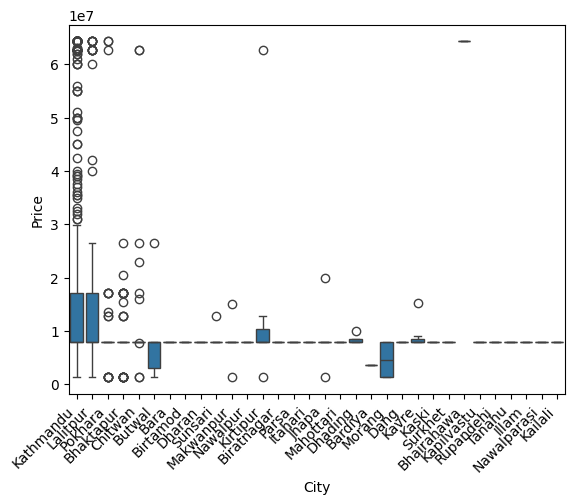

In [478]:
sns.boxplot(x = 'City', y = 'Price', data = cleanData)
plt.xticks(rotation=45, ha='right')
plt.show()

In [479]:
cleanData.loc[(cleanData['Year'] < year_q1_available) & (cleanData['Bathroom'] >= bath_median) & (cleanData['Bedroom'] >= bath_median), 'Price'] = int(cleanData['Price'].mean())
cleanData.loc[(cleanData['Year'] < year_q1_available) & ((cleanData['Bathroom'] >= bath_median) | (cleanData['Bedroom'] >= bath_median)), 'Price'] = int(np.quantile(cleanData['Price'], 0.25))
cleanData.loc[(cleanData['Year'] < year_q1_available) & (cleanData['Bathroom'] < bath_median) & (cleanData['Bedroom'] < bath_median), 'Price'] = price_q1

Bhaktapur

In [480]:
bhak_price_mean = int(cleanData[cleanData['City'] == "Bhaktapur"]['Price'].mean())
bhak_price_median = int(cleanData[cleanData['City'] == "Bhaktapur"]['Price'].median())

cleanData.loc[(cleanData['City'] == "Bhaktapur") & (cleanData['Year'] > year_md_available) & (cleanData['Bedroom'] <= cleanData[cleanData['City'] == "Bhaktapur"]['Bedroom'].median()) & (cleanData['Bedroom'] <= cleanData[cleanData['City'] == "Bhaktapur"]['Bathroom'].median()), 'Price'] = bhak_price_mean
cleanData.loc[(cleanData['City'] == "Bhaktapur") & (cleanData['Year'] <= year_md_available) & (cleanData['Bedroom'] <= cleanData[cleanData['City'] == "Bhaktapur"]['Bedroom'].median()) & (cleanData['Bedroom'] <= cleanData[cleanData['City'] == "Bhaktapur"]['Bathroom'].median()), 'Price'] = bhak_price_median

print(cleanData[(cleanData['City'] == 'Bhaktapur') & (cleanData['Price'] >= bhak_price_mean)][['Price', 'Year', 'Bedroom', 'Bathroom']])

        Price    Year  Bedroom  Bathroom
20    8952026  2076.0        1         3
38    8952026  2076.0        1         2
69    8952026  2076.0        1         4
825   8952026  2076.0        1         3
1514  8952026  2075.0        1         1
1552  8952026  2075.0        1         1
1585  8952026  2076.0        1         1
1678  8952026  2076.0        1         1
2070  8952026  2076.0        1         4


## New Updates

In [481]:
dropped_year = cleanData.dropna(subset='Year')

cleanData.loc[(cleanData['Year'] < year_q1_available) & (cleanData['NewArea(Aana)'] > farea_q3) & (cleanData['Price'] > price_lower), 'Price'] = price_lower
cleanData.loc[(cleanData['Year'] < year_q1_available) & (cleanData['NewArea(Aana)'] <= farea_q3) & (cleanData['NewArea(Aana)'] > farea_md) & (cleanData['Price'] > price_lower), 'Price'] = price_lowerer
cleanData.loc[(cleanData['Year'] < year_q1_available) & (cleanData['NewArea(Aana)'] <= farea_md) & (cleanData['Price'] > price_lower), 'Price'] = price_q1

## Visualization

Price Category Distribution

Price Category
High      1426
Medium     756
Low         29
Name: count, dtype: int64


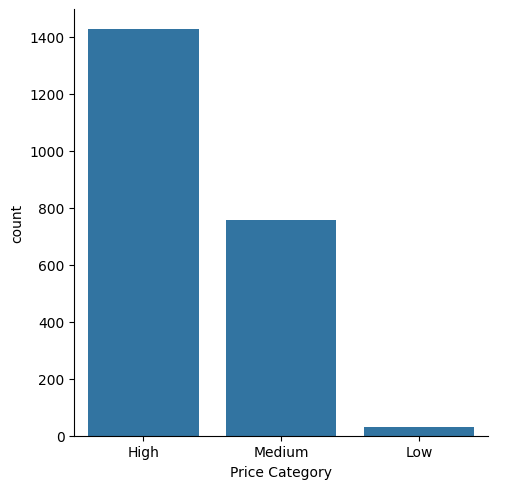

In [482]:
print(data['Price Category'].value_counts())
sns.catplot(kind='count', x = 'Price Category', data = data)

Price vs Bedroom & Bathroom

<Figure size 640x480 with 0 Axes>

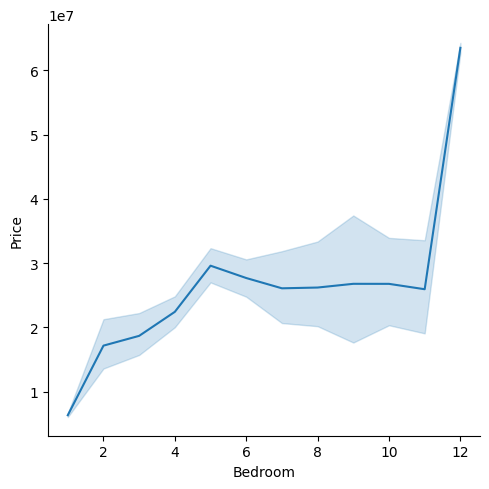

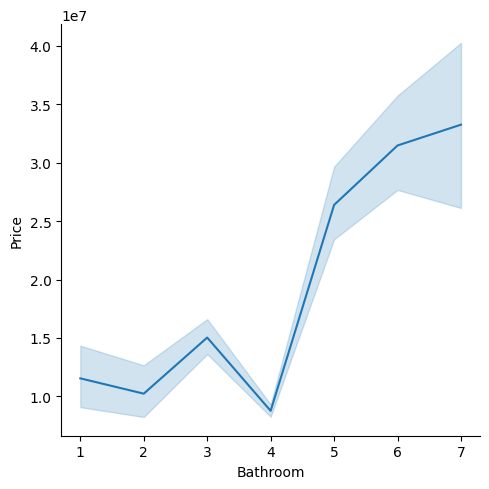

In [483]:
fig = plt.figure()
sns.relplot(x = 'Bedroom', y = 'Price', data = cleanData, kind='line')
sns.relplot(x = 'Bathroom', y = 'Price', data = cleanData, kind='line')

plt.show()

Relational Plot

<Axes: xlabel='Year', ylabel='Price'>

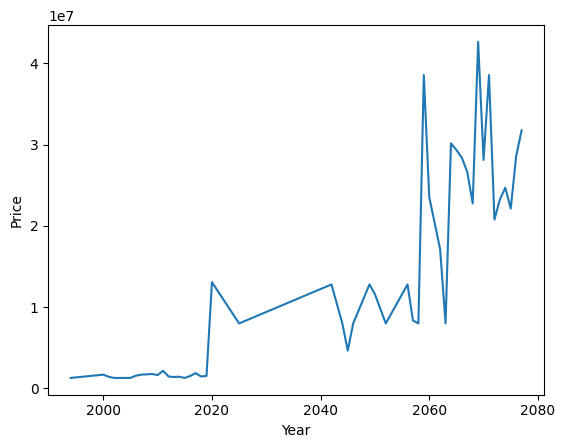

In [484]:
sns.lineplot(data = cleanData, x = 'Year', y = 'Price', errorbar=None)

<Axes: xlabel='NewArea(Aana)', ylabel='Price'>

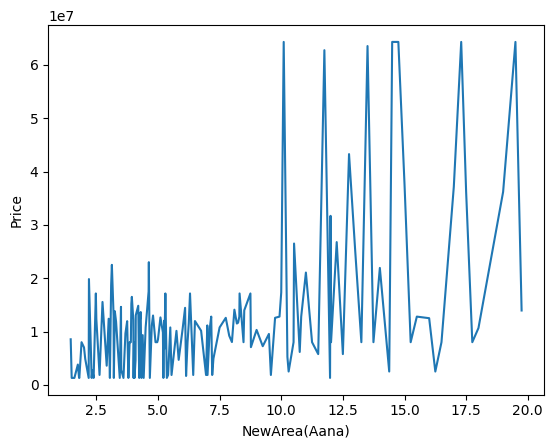

In [485]:
sns.lineplot(data = cleanData, x = "NewArea(Aana)", y = "Price", errorbar=None)

Categorical Plot

In [486]:
road_filtered_data = cleanData[(cleanData['City'].isin(cleanData['City'].value_counts().nlargest(5).index))]

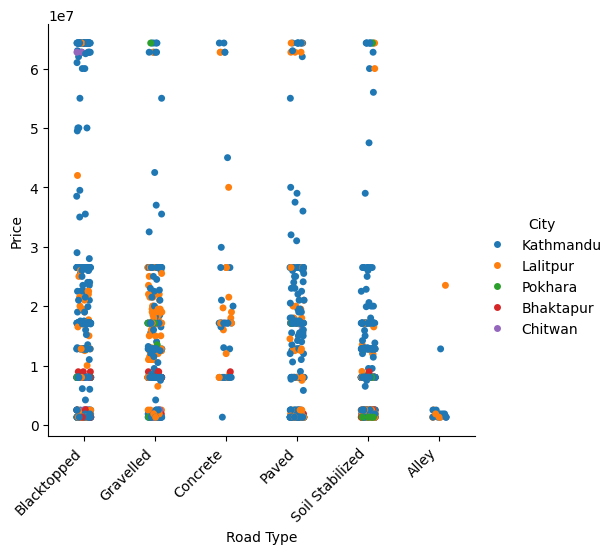

In [487]:
sns.catplot(x = 'Road Type', y = 'Price', hue='City', data = road_filtered_data, kind='strip')
plt.xticks(rotation = 45, ha = 'right')
plt.show()

Box Plot

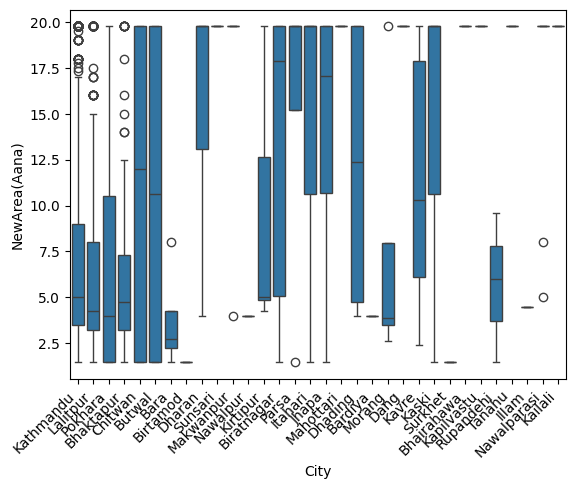

In [488]:
sns.boxplot(x = 'City', y = 'NewArea(Aana)', data = cleanData)
plt.xticks(rotation = 45, ha = 'right')
plt.show()


Distribution Analysis

<Axes: xlabel='Price', ylabel='Count'>

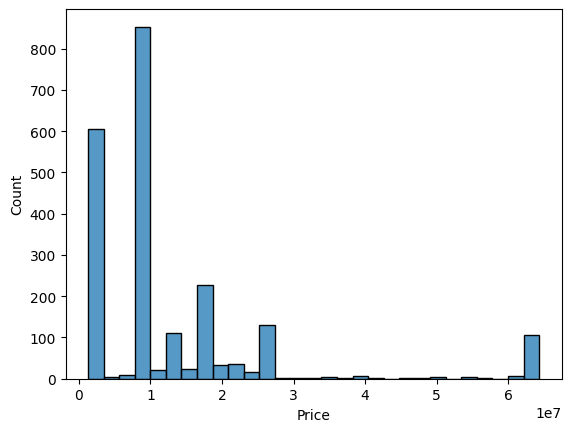

In [489]:
sns.histplot(x = 'Price', data = cleanData)

Categorical vs Categorical data visualization

In [490]:
pd.crosstab(cleanData['City'], cleanData['Amenities'])
pd.crosstab(cleanData['City'], cleanData['Road Type'])

Road Type,Alley,Blacktopped,Concrete,Gravelled,Paved,Soil Stabilized
City,,,,,,
Bara,0,0,0,0,0,4
Bardiya,0,0,0,0,0,1
Bhairahawa,0,0,0,0,1,0
Bhaktapur,0,29,1,18,3,34
Biratnagar,0,2,0,3,0,1
Birtamod,0,0,0,0,0,1
Butwal,1,2,0,2,0,1
Chitwan,1,15,1,7,2,7
Dang,0,0,0,0,0,1


In [491]:
# sns.pairplot(cleanData)

## HYPOTHESIS TESTING

Pearson correlation test(Area(x) and Price(y))

In [492]:
x_area = cleanData['NewArea(Aana)']
y_price = cleanData['Price']

null_hypo = "there is no significant linear relationship between Area and Price."
alt_hypo = "there is significant linear relationship between Area and Price."

corr_coefficient, p_val = pearsonr(x_area, y_price)

alpha = 0.05

if(p_val > alpha):
    print(f"Null hypothesis accepted, as the p-value({p_val}) > alpha({alpha}). So, {(null_hypo)}")
else:
    print(f"Null hypothesis rejected, as the p-value({p_val}) < alpha({alpha}). So, {(alt_hypo)}")

Null hypothesis rejected, as the p-value(4.944093883801786e-15) < alpha(0.05). So, there is significant linear relationship between Area and Price.


Pearson correlation test(Bedroom(x) and Price(y))

In [493]:
x_bed = cleanData['Bedroom']
y_price = cleanData['Price']

null_hypo = "there is no significant linear relationship between Bedroom and Price."
alt_hypo = "there is significant linear relationship between Bedroom and Price."

corr_coefficient, p_val = pearsonr(x_bed, y_price)

alpha = 0.05

if(p_val > alpha):
    print(f"Null hypothesis accepted, as the p-value({p_val}) > alpha({alpha}). So, {(null_hypo)}")
else:
    print(f"Null hypothesis rejected, as the p-value({p_val}) < alpha({alpha}). So, {(alt_hypo)}")

Null hypothesis rejected, as the p-value(5.480181959220646e-206) < alpha(0.05). So, there is significant linear relationship between Bedroom and Price.


Pearson correlation test(Bathroom(x) and Price(y))

In [494]:
x_bath = cleanData['Bathroom']
y_price = cleanData['Price']

null_hypo = "there is no significant linear relationship between Bathroom and Price."
alt_hypo = "there is significant linear relationship between Bathroom and Price."

corr_coefficient, p_val = pearsonr(x_bath, y_price)

alpha = 0.05

if(p_val > alpha):
    print(f"Null hypothesis accepted, as the p-value({p_val}) > alpha({alpha}). So, {(null_hypo)}")
else:
    print(f"Null hypothesis rejected, as the p-value({p_val}) < alpha({alpha}). So, {(alt_hypo)}")

Null hypothesis rejected, as the p-value(4.151152701753749e-32) < alpha(0.05). So, there is significant linear relationship between Bathroom and Price.


Pearson correlation test(Parking(x) and Price(y))

In [495]:
x_parking = cleanData['Parking']
y_price = cleanData['Price']

null_hypo = "there is no significant linear relationship between Parking and Price."
alt_hypo = "there is significant linear relationship between Parking and Price."

corr_coefficient, p_val = pearsonr(x_parking, y_price)

alpha = 0.05

if(p_val > alpha):
    print(f"Null hypothesis accepted, as the p-value({p_val}) > alpha({alpha}). So, {(null_hypo)}")
else:
    print(f"Null hypothesis rejected, as the p-value({p_val}) < alpha({alpha}). So, {(alt_hypo)}")

Null hypothesis rejected, as the p-value(3.21670241482984e-81) < alpha(0.05). So, there is significant linear relationship between Parking and Price.


ANOVA table for (City(x) and Price(y))

In [496]:
null_hypo = "there is no significant difference between the mean price of the cities."
alt_hypo = "there is significant difference between the mean price of the cities."

anova_results = pg.anova(dv='Price', between='City', data=cleanData)
p_val = anova_results['p-unc'][0]

if(p_val > 0.05):
    print(f"Null hypothesis accepted, as the p-value({p_val}) > alpha({alpha}). So, {(null_hypo)}")
else:
    print(f"Null hypothesis rejected, as the p-value({p_val}) < alpha({alpha}). So, {(alt_hypo)}")


Null hypothesis rejected, as the p-value(9.143563127156617e-10) < alpha(0.05). So, there is significant difference between the mean price of the cities.


Paired test

In [497]:
city_paired = pg.pairwise_tests( dv='Price', between='City', data=road_filtered_data, padjust='bonferroni')
print(city_paired)

  Contrast          A          B  Paired  Parametric          T         dof  \
0     City  Bhaktapur    Chitwan   False        True  -1.612467   33.050376   
1     City  Bhaktapur  Kathmandu   False        True -15.872093  470.994054   
2     City  Bhaktapur   Lalitpur   False        True  -6.571096  488.567030   
3     City  Bhaktapur    Pokhara   False        True  -2.014705   68.096783   
4     City    Chitwan  Kathmandu   False        True  -1.573527   33.605592   
5     City    Chitwan   Lalitpur   False        True  -0.055772   35.222902   
6     City    Chitwan    Pokhara   False        True   0.267759   58.327254   
7     City  Kathmandu   Lalitpur   False        True   5.644438  907.237290   
8     City  Kathmandu    Pokhara   False        True   2.913013   70.930762   
9     City   Lalitpur    Pokhara   False        True   0.555552   79.069717   

  alternative         p-unc        p-corr    p-adjust       BF10    hedges  
0   two-sided  1.163700e-01  1.000000e+00  bonferroni

In [498]:
significant_pairs = city_paired[city_paired['p-corr'] < 0.05]

print(significant_pairs)

  Contrast          A          B  Paired  Parametric          T         dof  \
1     City  Bhaktapur  Kathmandu   False        True -15.872093  470.994054   
2     City  Bhaktapur   Lalitpur   False        True  -6.571096  488.567030   
7     City  Kathmandu   Lalitpur   False        True   5.644438  907.237290   
8     City  Kathmandu    Pokhara   False        True   2.913013   70.930762   

  alternative         p-unc        p-corr    p-adjust       BF10    hedges  
1   two-sided  9.391120e-46  9.391120e-45  bonferroni  1.001e+49 -0.544838  
2   two-sided  1.282746e-10  1.282746e-09  bonferroni  6.441e+07 -0.395709  
7   two-sided  2.215555e-08  2.215555e-07  bonferroni  3.789e+05  0.266152  
8   two-sided  4.783669e-03  4.783669e-02  bonferroni      7.748  0.316836  


Perform Cohen's d test

In [499]:
def cohens_d(group1, group2):
    diff = group1.mean() - group2.mean()
    n1, n2 = len(group1), len(group2)
    var1, var2 = group1.var(), group2.var()
    pooled_std = np.sqrt(((n1 - 1) * var1 + (n2 - 1) * var2) / (n1 + n2 - 2))
    d = diff/pooled_std
    return d


Bhaktapur & Kathmandu

In [500]:
bhak_price = cleanData[cleanData['City'] == 'Bhaktapur']['Price']
kath_price = cleanData[cleanData['City'] == 'Kathmandu']['Price']

cohens_d_bk = cohens_d(bhak_price, kath_price)
print(cohens_d_bk)

-0.5450995801407662


Chitwan & Kathmandu

In [501]:
chit_price = cleanData[cleanData['City'] == 'Chitwan']['Price']
kath_price = cleanData[cleanData['City'] == 'Kathmandu']['Price']

cohens_d_ck = cohens_d(chit_price, kath_price)
print(cohens_d_ck)

-0.26301301839617386


Chitwan & Lalitpur

In [502]:
chit_price = cleanData[cleanData['City'] == 'Chitwan']['Price']
lalit_price = cleanData[cleanData['City'] == 'Lalitpur']['Price']

cohens_d_lk = cohens_d(chit_price, lalit_price)
print(cohens_d_lk)

-0.01215676798153967


Kathmandu & Lalitpur

In [503]:
kath_price = cleanData[cleanData['City'] == 'Kathmandu']['Price']
lalit_price = cleanData[cleanData['City'] == 'Lalitpur']['Price']

cohens_d_kl = cohens_d(kath_price, lalit_price)
print(cohens_d_kl)

0.2662565259309512


Kathmandu & Pokhara

In [504]:
kath_price = cleanData[cleanData['City'] == 'Kathmandu']['Price']
pokh_price = cleanData[cleanData['City'] == 'Pokhara']['Price']

cohens_d_kp = cohens_d(kath_price, pokh_price)
print(cohens_d_kp)

0.3169898305062391


## Preprocessing Started

Frequency Encoding

In [505]:
from collections import Counter

city_frequency = Counter(cleanData['City'])

cleanData['City_Encoded'] = cleanData['City'].map(city_frequency)

cleanData['Amenities'] = cleanData['Amenities'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

all_amenities = [item for sublist in cleanData['Amenities'] for item in sublist]
amenity_counts = Counter(all_amenities)

cleanData['Amenities_Score'] = cleanData['Amenities'].apply(lambda x: sum(amenity_counts.get(amenity, 0) for amenity in x))

print(amenity_counts)
print(cleanData[['Amenities', 'Amenities_Score']])

Counter({'Water Supply': 877, 'Drainage': 800, 'Balcony': 777, 'Water Tank': 726, 'TV Cable': 621, 'Wifi': 476, 'Solar Water': 406, 'Parking': 398, 'Modular Kitchen': 397, 'Garden': 393, 'Water Well': 352, 'Garage': 339, 'Frontyard': 274, 'Fencing': 263, 'Internet': 220, 'Backyard': 210, 'Lawn': 189, 'Electricity Backup': 157, 'Store Room': 148, 'Washing Machine': 126, 'Air Condition': 119, 'Microwave': 111, 'Deck': 101, 'Kids Playground': 90, 'CCTV': 59, 'Gym': 51, 'Swimming Pool': 46, 'Intercom': 41, 'Security Staff': 37, 'Cafeteria': 26, 'Lift': 20, 'Maintenance': 20, 'Jacuzzi': 10})
                                              Amenities  Amenities_Score
0     [Parking, Lawn, Garage, Frontyard, Fencing, Ba...             7498
1     [Parking, Garage, Fencing, Frontyard, Balcony,...             7309
2     [Parking, Lawn, Garage, Frontyard, Fencing, Ba...             7498
3     [Parking, Lawn, Garage, Frontyard, Fencing, Ba...             7498
4     [Parking, Lawn, Garage, Balcony, Ba

32


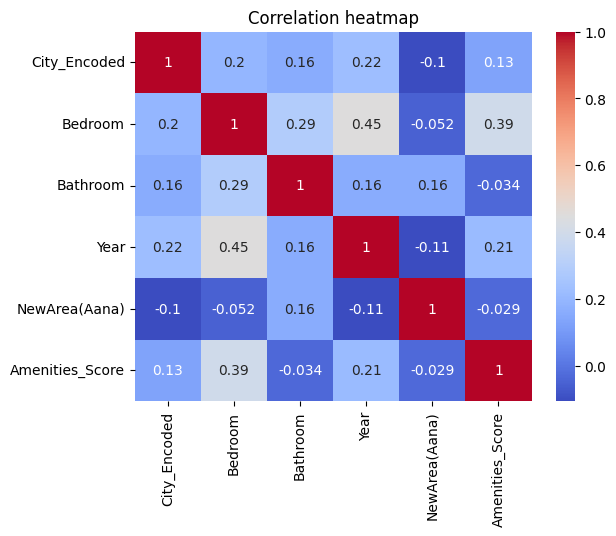

       Year    Price  NewArea(Aana)
3    2017.0  2500000          10.25
6    2019.0  2500000          19.75
8    2017.0  2500000          12.75
56   2018.0  1300000           3.00
63   2017.0  1850000           7.00
67   2017.0  1300000           6.00
105  2007.0  1300000           1.46
106  2007.0  1850000          10.00
108  2007.0  1300000           4.00
112  2003.0  1300000           1.46
113  2007.0  1300000           4.00
120  2007.0  1300000           3.00
124  2007.0  1300000           5.50
126  2007.0  1300000           2.92
129  2007.0  1300000          10.00
133  2007.0  1300000           1.46
135  2007.0  1300000           1.46
137  2013.0  1850000           9.00
146  2007.0  1300000           1.46
147  2007.0  1300000           1.46
148  2007.0  2500000          10.75
149  2007.0  1300000           4.09
152  2007.0  2500000          19.75
156  2007.0  1300000           4.42
157  2007.0  2500000          19.75
159  2007.0  1300000           2.63
160  2007.0  1300000        

In [506]:
print(len(cleanData['City'].unique()))
features_cleanData = cleanData[['City_Encoded', 'Bedroom', 'Bathroom', 'Year', 'NewArea(Aana)', 'Amenities_Score']]

corr_matrix = features_cleanData.corr()

sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation heatmap")
plt.show()

print(cleanData[cleanData['Year'] < 2020][['Year', 'Price', 'NewArea(Aana)']].head(50))


Split Data

In [507]:
X = cleanData[['City_Encoded', 'Bedroom', 'Bathroom', 'Year', 'NewArea(Aana)', 'Amenities_Score']].values
y = cleanData['Price'].values
SEED = 42

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

Linear & Lasso Regression

In [508]:
# scaler = StandardScaler()
# X_train_scale = scaler.fit_transform(X_train)
# X_test_scale = scaler.transform(X_test)

# lin_reg = LinearRegression()
# lin_reg.fit(X_train_scale, y_train)

# y_pred = lin_reg.predict(X_test_scale)

# lasso_cv = Lasso(alpha=100000)
# lasso_cv.fit(X_train_scale, y_train)

# y_pred_l = lasso_cv.predict(X_test_scale)

# print(y_pred_l)

# def root_mean_squared_error(y_true, y_pred):
#     return np.sqrt(mean_squared_error(y_true, y_pred))

# print(f"LinReg Scores: {lin_reg.score(X_test_scale, y_test)}, {mean_squared_error(y_test, y_pred)}, {root_mean_squared_error(y_test, y_pred)}")
# print(f"Lasso Scores: {lasso_cv.score(X_test_scale, y_test)}, {mean_squared_error(y_test, y_pred_l)}, {root_mean_squared_error(y_test, y_pred_l)}")


Sending Dataframe column

In [509]:
with open("amenities.pkl", "wb") as f:
    pk.dump(cleanData['Amenities'].tolist(), f)

Random Forest

In [510]:
rf_regressor = RandomForestRegressor(n_estimators=250, max_depth=5, random_state=SEED)
rf_regressor.fit(X_train, y_train)

y_pred_rf_train = rf_regressor.predict(X_train)
y_pred_rf_test = rf_regressor.predict(X_test)

r2_train = r2_score(y_train, y_pred_rf_train)
r2_test = r2_score(y_test, y_pred_rf_test)
mse_train = mean_squared_error(y_train, y_pred_rf_train)
mse_test = mean_squared_error(y_test, y_pred_rf_test)
rmse_train = np.sqrt(mse_train)
rmse_test = np.sqrt(mse_test)

print(f"Random Forest R²[train]: {r2_train}")
print(f"Random Forest Mean Squared Error (MSE)[train]: {mse_train}")
print(f"Random Forest Root Mean Squared Error (RMSE)[train]: {rmse_train}")
print(f"Random Forest R²[test]: {r2_test}")
print(f"Random Forest Mean Squared Error (MSE)[test]: {mse_test}")
print(f"Random Forest Root Mean Squared Error (RMSE)[test]: {rmse_test}")

with open("model.pkl", "wb") as file:
    pk.dump(rf_regressor, file)

print("Model saved as model.pkl")

Random Forest R²[train]: 0.9540437024917843
Random Forest Mean Squared Error (MSE)[train]: 9554622236249.576
Random Forest Root Mean Squared Error (RMSE)[train]: 3091055.197865217
Random Forest R²[test]: 0.914744415525377
Random Forest Mean Squared Error (MSE)[test]: 16228133731363.693
Random Forest Root Mean Squared Error (RMSE)[test]: 4028415.7843206422
Model saved as model.pkl


Hyperparameter Tuned Random Forest

In [511]:
# rf = RandomForestRegressor()

# params_rf = {
#     'n_estimators': [50, 100],
#     'max_depth': [None, 1, 5, 10],
#     'min_samples_split': [2, 10],
#     'min_samples_leaf': [1, 2]
# }

# grid_rf = GridSearchCV(estimator=rf, param_grid=params_rf, cv = 3, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)

# grid_rf.fit(X_train, y_train)

# best_hyperparams = grid_rf.best_params_

# print(best_hyperparams)

In [512]:
# best_model = grid_rf.best_estimator_

# y_pred_hprf = best_model.predict(X_test)

# mse_hprf = mean_squared_error(y_test, y_pred_hprf)

# r2_hprf = r2_score(y_test, y_pred_hprf)
# rmse_test_hprf = mse_hprf**(1/2)
# print(r2_hprf, mse_hprf, rmse_test_hprf)

Important Features

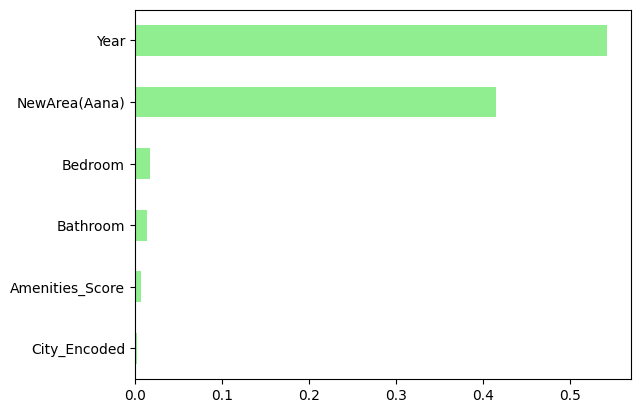

In [513]:
importances_rf = pd.Series(rf_regressor.feature_importances_, index = ['City_Encoded', 'Bedroom', 'Bathroom', 'Year', 'NewArea(Aana)', 'Amenities_Score'])
sorted_importances_rf = importances_rf.sort_values()

sorted_importances_rf.plot(kind='barh', color='lightgreen')
plt.show()

Boosting Methods

Ada Boost

In [514]:
# dt = DecisionTreeRegressor(max_depth=10)

# adb_reg = AdaBoostRegressor(estimator=dt, n_estimators=100, random_state=SEED)

# adb_reg.fit(X_train, y_train)

# adb_reg_pred_train = adb_reg.predict(X_train)
# adb_reg_pred_test = adb_reg.predict(X_test)

# r2_adb_train = r2_score(y_train, adb_reg_pred_train)
# mse_adb_train = mean_squared_error(y_train, adb_reg_pred_train)
# rmse_adb_train = np.sqrt(mse_adb_train)
# r2_adb_test = r2_score(y_test, adb_reg_pred_test)
# mse_adb_test = mean_squared_error(y_test, adb_reg_pred_test)
# rmse_adb_test = np.sqrt(mse_adb_train)

# print(f"AdaBoosting R²[train]: {r2_adb_train}")
# print(f"AdaBoosting Mean Squared Error (MSE)[train]: {mse_adb_train}")
# print(f"AdaBoosting Root Mean Squared Error (RMSE)[train]: {rmse_adb_train}")
# print(f"AdaBoosting R²[test]: {r2_adb_test}")
# print(f"AdaBoosting Mean Squared Error (MSE)[test]: {mse_adb_test}")
# print(f"AdaBoosting Root Mean Squared Error (RMSE)[test]: {rmse_adb_test}")

Gradient Boost

In [515]:
# grd_reg = GradientBoostingRegressor(random_state=SEED)

# grd_reg.fit(X_train, y_train)

# grd_reg_pred_train = grd_reg.predict(X_train)
# grd_reg_pred_test = grd_reg.predict(X_test)

# r2_grd_train = r2_score(y_train, grd_reg_pred_train)
# mse_grd_train = mean_squared_error(y_train, grd_reg_pred_train)
# rmse_grd_train = np.sqrt(mse_grd_train)
# r2_grd_test = r2_score(y_test, grd_reg_pred_test)
# mse_grd_test = mean_squared_error(y_test, grd_reg_pred_test)
# rmse_grd_test = np.sqrt(mse_grd_test)

# print(f"AdaBoosting R²[train]: {r2_grd_train}")
# print(f"AdaBoosting Mean Squared Error (MSE)[train]: {mse_grd_train}")
# print(f"AdaBoosting Root Mean Squared Error (RMSE)[train]: {rmse_grd_train}")
# print(f"AdaBoosting R²[test]: {r2_grd_test}")
# print(f"AdaBoosting Mean Squared Error (MSE)[test]: {mse_grd_test}")
# print(f"AdaBoosting Root Mean Squared Error (RMSE)[test]: {rmse_grd_test}")

Hyperparameter Tuning

In [516]:
# param_grd = {
#     'n_estimators': [50, 100],
#     'learning_rate': [0.01, 0.1, 0.2],
#     'max_depth': [3, 5],
#     'min_samples_split': [5, 10],
#     'subsample': [0.8, 0.9]
# }

# grid_reg = GridSearchCV(estimator=grd_reg, param_grid=param_grd, cv = 3, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)

# grid_reg.fit(X_train, y_train)

# best_hyper_params_grid = grid_reg.best_params_
